<a href="https://www.kaggle.com/code/dheerajkr1a1a/chennai-retail-prices-forecast?scriptVersionId=212743616" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Citations:
For Citing this notebook please follow this DOI: https://doi.org/10.5281/zenodo.10212265

# Why only Chennai?
It is the city with largest datasize and maximum arrival quantity across all centres.

Source:
https://www.kaggle.com/code/dheerajkr1a1a/tomato-centre-wise-data-analysis

# Objective
The goal is to utilize the prophet multivariate time series model to forecast the spot prices of tomatoes at the Chennai center, incorporating both macroeconomic and climate-related variables.

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default='plotly_white'
import os
# import plotly.io as pio
# pio.renderers.default = 'colab'
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
#from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots
import itertools
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5



# Reading & plotting complete data for Ranchi center

In [2]:
parent_df={}
parent_df['RANCHI']=pd.read_csv('/kaggle/input/chennai-tomato-retail-prices-analysis/complete_data.csv',index_col=0,parse_dates=[0])

In [3]:
# sns.lineplot(data=parent_df['RANCHI'])

parent_df['RANCHI'].iplot()

# Plotting only Retail Prices & Arrival Quantity

In [4]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Retail Prices','Arrival Quantity'])

# Plotting Retail Prices

In [5]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y='Retail Prices')

# Plotting Arrival Quantity

In [6]:
parent_df['RANCHI']['Arrival Quantity'].iplot(xTitle='Date',yTitle='Arrival Quantity')

# Dropping the outliers with retail prices less than threshold set for keeping the data
**For example here 10k is the threshold and three values are 9k,8k and 4.5k being the local outliers will not be dropped.**

In [7]:
parent_df['RANCHI'].drop(['2014-01-30','2014-02-10','2011-12-07'],inplace=True)

# Looking for the changes

In [8]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Retail Prices','Arrival Quantity'])

In [9]:
parent_df['RANCHI'].loc['2010':'2019','Arrival Quantity'].isnull().sum()

843

# Filling null with -1 to prevent them from being lost when applying condition of dropping outliers

In [10]:
parent_df['RANCHI']['Arrival Quantity'].fillna(-1,inplace=True)

In [11]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6755 entries, 2002-01-01 to 2022-03-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  6755 non-null   float64
 1   Retail Prices     4343 non-null   float64
 2   Min Price         4343 non-null   float64
 3   Max Price         4343 non-null   float64
 4   Modal Price       4343 non-null   float64
dtypes: float64(5)
memory usage: 574.7 KB


# Condition of dropping outliers

In [12]:
parent_df['RANCHI']=parent_df['RANCHI'][(parent_df['RANCHI']['Arrival Quantity']<=500)]

In [13]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6719 entries, 2002-01-01 to 2022-03-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  6719 non-null   float64
 1   Retail Prices     4307 non-null   float64
 2   Min Price         4307 non-null   float64
 3   Max Price         4307 non-null   float64
 4   Modal Price       4307 non-null   float64
dtypes: float64(5)
memory usage: 315.0 KB


# Arrival qty without outliers

In [14]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Arrival Quantity'])

# Getting back the null values for easier analysis

In [15]:
parent_df['RANCHI']['Arrival Quantity'].replace(-1,np.nan,inplace=True)

In [16]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6719 entries, 2002-01-01 to 2022-03-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  4307 non-null   float64
 1   Retail Prices     4307 non-null   float64
 2   Min Price         4307 non-null   float64
 3   Max Price         4307 non-null   float64
 4   Modal Price       4307 non-null   float64
dtypes: float64(5)
memory usage: 315.0 KB


In [17]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Arrival Quantity'])

# Filling null with 1000 to prevent them from being lost when applying condition of dropping downward outliers

In [18]:
parent_df['RANCHI']['Arrival Quantity'].fillna(1000,inplace=True)

In [19]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6719 entries, 2002-01-01 to 2022-03-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  6719 non-null   float64
 1   Retail Prices     4307 non-null   float64
 2   Min Price         4307 non-null   float64
 3   Max Price         4307 non-null   float64
 4   Modal Price       4307 non-null   float64
dtypes: float64(5)
memory usage: 315.0 KB


# Condition of dropping downward outliers

In [20]:
parent_df['RANCHI']=parent_df['RANCHI'][(parent_df['RANCHI']['Arrival Quantity']>=180)]

In [21]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6631 entries, 2002-01-01 to 2022-03-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  6631 non-null   float64
 1   Retail Prices     4219 non-null   float64
 2   Min Price         4219 non-null   float64
 3   Max Price         4219 non-null   float64
 4   Modal Price       4219 non-null   float64
dtypes: float64(5)
memory usage: 310.8 KB


# Getting back the null values for easier analysis

In [22]:
parent_df['RANCHI']['Arrival Quantity'].replace(1000,np.nan,inplace=True)

In [23]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6631 entries, 2002-01-01 to 2022-03-31
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  4219 non-null   float64
 1   Retail Prices     4219 non-null   float64
 2   Min Price         4219 non-null   float64
 3   Max Price         4219 non-null   float64
 4   Modal Price       4219 non-null   float64
dtypes: float64(5)
memory usage: 310.8 KB


In [24]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Arrival Quantity'])

In [25]:
df_Ranchi=parent_df['RANCHI'].copy()

In [26]:
df_Ranchi['2010':'2020'].describe()

Arrival Quantity  Retail Prices    Min Price     Max Price  Modal Price
count       2911.000000    2911.000000  2911.000000   2911.000000  2911.000000
mean         364.523531    2201.703882  1361.278598   1536.432841  1441.923738
std           50.994980    1389.081472  1050.404299   1137.618603  1071.981724
min          180.000000       0.000000    90.000000    300.000000   237.000000
25%          330.000000    1200.000000   700.000000    800.000000   750.000000
50%          360.000000    1800.000000  1000.000000   1200.000000  1100.000000
75%          400.000000    2800.000000  1600.000000   1800.000000  1700.000000
max          500.000000   14000.000000  8000.000000  14000.000000  8300.000000

# Visualising the data with outliers 

In [27]:
df_Ranchi['2010':'2020']['Retail Prices'].iplot()

# Creating cleaned copy of data for ACF plots and adf test 

In [28]:
df_Ranchi_1=df_Ranchi.copy()
df_Ranchi.isnull().sum()

Arrival Quantity    2412
Retail Prices       2412
Min Price           2412
Max Price           2412
Modal Price         2412
dtype: int64

# Dropping Retail Prices Outliers

In [29]:
# https://www.ceicdata.com/en/india/retail-price-department-of-agriculture-and-cooperation-food-by-cities-tomato/retail-price-doac-tomato-tamil-nadu-chennai

df_Ranchi_1=df_Ranchi_1[df_Ranchi_1['Retail Prices']<10000]
df_Ranchi_1.isnull().sum()


Arrival Quantity    0
Retail Prices       0
Min Price           0
Max Price           0
Modal Price         0
dtype: int64

In [30]:
df_Ranchi=df_Ranchi['2010':'2020'].copy()


In [31]:
df_Ranchi_1=df_Ranchi_1['2010':'2020'].copy()
df_Ranchi_1.isnull().sum()

Arrival Quantity    0
Retail Prices       0
Min Price           0
Max Price           0
Modal Price         0
dtype: int64

In [32]:
df_Ranchi_dropped=df_Ranchi_1.dropna()

In [33]:
df_Ranchi_dropped['Arrival Quantity'].iplot()

In [34]:
px.line(df_Ranchi_dropped,x=df_Ranchi_dropped.index,y='Retail Prices')

In [35]:
df_Ranchi_dropped.loc[:,['Arrival Quantity','Retail Prices']].iplot(subplots=True)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

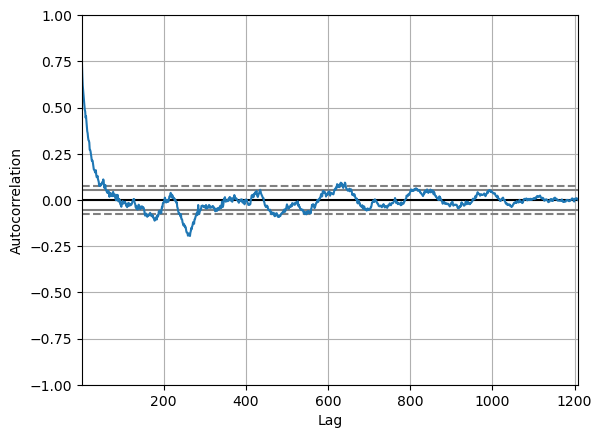

In [36]:
pd.plotting.autocorrelation_plot(df_Ranchi_dropped['2016':'2020']['Arrival Quantity'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

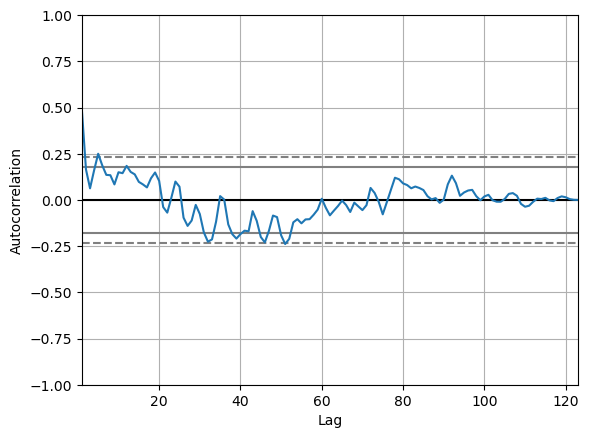

In [37]:
pd.plotting.autocorrelation_plot(df_Ranchi_dropped['2010':'2020']['Arrival Quantity'].resample('1m').max())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

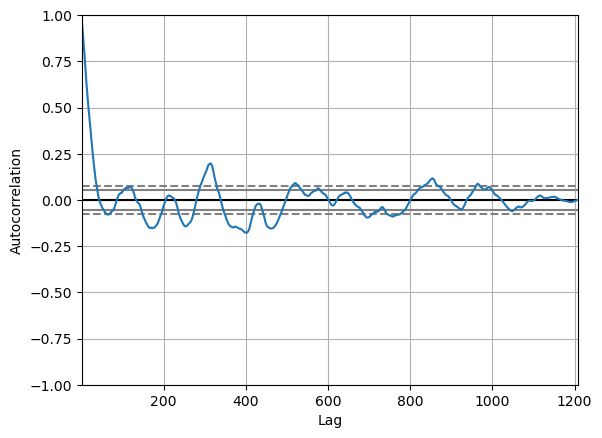

In [38]:
pd.plotting.autocorrelation_plot(df_Ranchi_dropped['2016':'2020']['Retail Prices'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

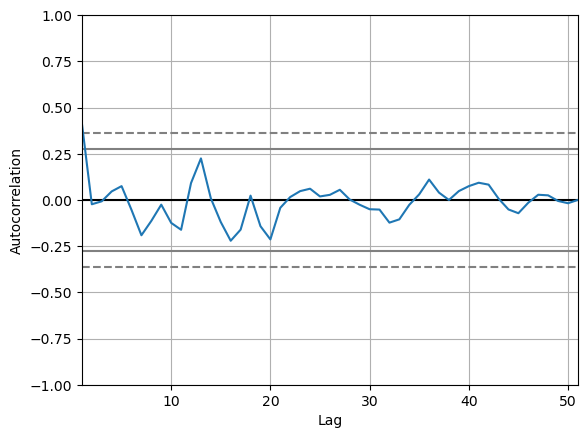

In [39]:
pd.plotting.autocorrelation_plot(df_Ranchi_dropped['2016':'2020']['Retail Prices'].resample('1m').max())

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

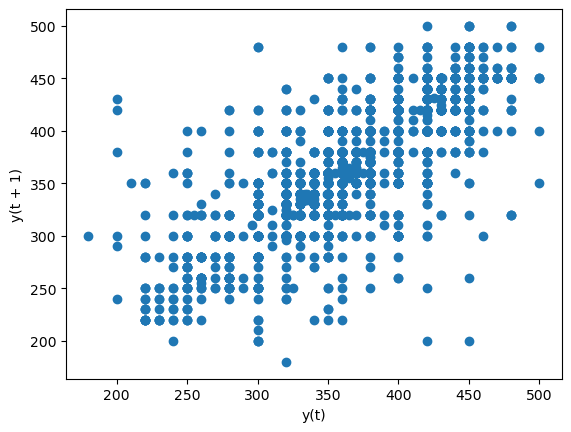

In [40]:
pd.plotting.lag_plot(df_Ranchi_1['Arrival Quantity'],lag=1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

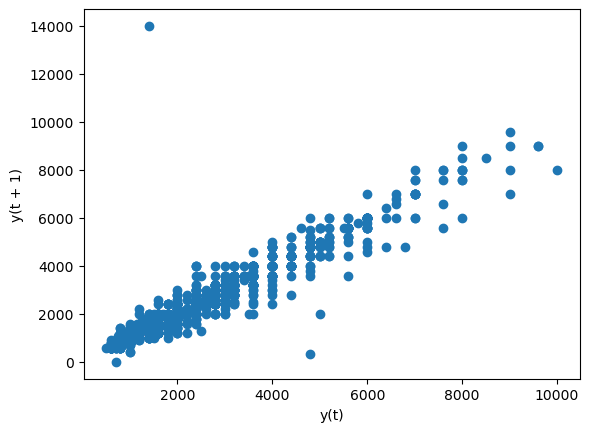

In [41]:
pd.plotting.lag_plot(df_Ranchi['Retail Prices'],lag=1)

In [42]:
from statsmodels.tsa.stattools import adfuller


# In[19]:


test_result=adfuller(df_Ranchi_dropped['Arrival Quantity'])


# In[20]:


#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [43]:
adfuller_test(df_Ranchi_dropped['Arrival Quantity'])

ADF Test Statistic : -5.779550527279977
p-value : 5.164072535902572e-07
#Lags Used : 22
Number of Observations Used : 2886
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [44]:
adfuller_test(df_Ranchi_dropped['Retail Prices'])

ADF Test Statistic : -6.783209719019895
p-value : 2.4692521365595217e-09
#Lags Used : 4
Number of Observations Used : 2904
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [45]:
df_Ranchi.isnull().sum()

Arrival Quantity    868
Retail Prices       868
Min Price           868
Max Price           868
Modal Price         868
dtype: int64

# Applying similar procedure to drop outliers without losing NULL

In [46]:
df_Ranchi.fillna(-1,inplace=True)
df_Ranchi=df_Ranchi[df_Ranchi['Retail Prices']<10000]
df_Ranchi.replace(-1,np.nan,inplace=True)

In [47]:
df_Ranchi

Arrival Quantity  Retail Prices  Min Price  Max Price  Modal Price
Date                                                                          
2010-01-01             320.0         2000.0     1100.0     1200.0       1150.0
2010-01-02             250.0         2000.0     1000.0     1100.0       1050.0
2010-01-03             380.0         2400.0     1400.0     1600.0       1500.0
2010-01-04             400.0         2000.0     1100.0     1200.0       1150.0
2010-01-05             400.0         2000.0     1100.0     1200.0       1150.0
...                      ...            ...        ...        ...          ...
2020-03-27               NaN            NaN        NaN        NaN          NaN
2020-03-28               NaN            NaN        NaN        NaN          NaN
2020-03-29               NaN            NaN        NaN        NaN          NaN
2020-03-30               NaN            NaN        NaN        NaN          NaN
2020-03-31               NaN            NaN        NaN        NaN          NaN

[3777 rows x 5 columns]

# Imputing with rolling window size = adf lags

In [48]:
df_Ranchi_imp=pd.DataFrame()
df_Ranchi_imp['Retail Prices']=df_Ranchi['Retail Prices'].rolling(window=4,min_periods=2).mean().fillna(method='ffill')
df_Ranchi_imp['Arrival Quantity']=df_Ranchi['Arrival Quantity'].rolling(window=22,min_periods=11).mean().fillna(method='ffill')
df_Ranchi_imp['Retail Prices_lag']=df_Ranchi['Retail Prices'].rolling(window=4,min_periods=2).mean().fillna(method='ffill').shift(1)
# df_Ranchi_imp['Arrival Quantity']=df_Ranchi['Arrival Quantity'].rolling(window=5,min_periods=2).mean().fillna(method='bfill')
df_Ranchi_imp=df_Ranchi_imp.dropna()
#df_Ranchi_imp['2008':'2016']['Retail Prices'].plot()
df_Ranchi_imp[['Retail Prices','Retail Prices_lag']].iplot()
df_Ranchi_imp.isnull().sum()

Retail Prices        0
Arrival Quantity     0
Retail Prices_lag    0
dtype: int64

# Resampling daily data into monthly data

In [49]:
df_Ranchi_imp_month=pd.DataFrame()
df_Ranchi_imp_month['Retail Prices_lag']=df_Ranchi_imp['Retail Prices_lag'].resample('M').mean()
df_Ranchi_imp_month['Arrival Quantity']=df_Ranchi_imp['Arrival Quantity'].resample('M').max()
df_Ranchi_imp_month['Arrival Quantity_mean']=df_Ranchi_imp['Arrival Quantity'].resample('M').sum()
df_Ranchi_imp_month=df_Ranchi_imp_month.dropna()
df_Ranchi_imp_month.index = df_Ranchi_imp_month.index + pd.offsets.MonthBegin(0)
df_Ranchi_imp_month[['Arrival Quantity','Retail Prices_lag']].tail(6)

Arrival Quantity  Retail Prices_lag
Date                                           
2019-11-01        402.777778        3753.763441
2019-12-01        373.333333        3282.795699
2020-01-01        371.764706        2720.161290
2020-02-01        407.777778        2456.989247
2020-03-01        402.352941        1766.666667
2020-04-01        401.250000        1613.978495

In [50]:
df_Ranchi_imp_month

Retail Prices_lag  Arrival Quantity  Arrival Quantity_mean
Date                                                                  
2010-02-01        1628.571429        382.777778            7694.600912
2010-03-01         928.333333        436.875000           12587.995399
2010-04-01         801.075269        435.000000           13093.057589
2010-05-01        1328.494624        415.294118           11923.100490
2010-06-01        2531.720430        322.941176            9716.699346
...                       ...               ...                    ...
2019-12-01        3282.795699        373.333333           11369.738562
2020-01-01        2720.161290        371.764706           11291.781906
2020-02-01        2456.989247        407.777778           12073.359133
2020-03-01        1766.666667        402.352941           12040.849673
2020-04-01        1613.978495        401.250000           12003.700047

[123 rows x 3 columns]

# Reading csv file (Fertilizer subsidy rates, Diesel Reserves and Diesel Prices) 

In [51]:
df_1_new=pd.read_csv('/kaggle/input/chennai-tomato-retail-prices-analysis/Fert_chennai_dies_price.csv',index_col=[0],parse_dates=True)
df_1_new

N       P       K      S  thousand million barrels  \
2002-06-01  23.227  26.276  24.487  1.784                       5.8   
2002-10-01  23.227  26.276  24.487  1.784                       5.8   
2002-12-01  23.227  26.276  24.487  1.784                       5.8   
2003-03-01  23.227  26.276  24.487  1.784                       5.8   
2003-04-01  23.227  26.276  24.487  1.784                       5.8   
...            ...     ...     ...    ...                       ...   
2021-10-01  18.901  15.216  11.124  3.562                       4.7   
2022-02-01  18.901  15.216  11.124  3.562                       4.7   
2022-03-01  18.901  15.216  11.124  3.562                       4.7   
2022-04-01  18.901  15.216  11.124  3.562                       4.7   
2023-03-01  18.901  15.216  11.124  3.562                       4.7   

                dprice  
2002-06-01   19.969788  
2002-10-01   21.631415  
2002-12-01   19.063444  
2003-03-01   24.048338  
2003-04-01   21.329305  
...                ...  
2021-10-01   91.268885  
2022-02-01   91.722057  
2022-03-01  100.785501  
2022-04-01   97.688823  
2023-03-01   94.592145  

[79 rows x 6 columns]

In [52]:
#df_1_new=pd.read_csv('FERTILIZERS.csv',names=['Date','N','P','K','S'],header=0,index_col=[0],parse_dates=True)
finaldf1=df_Ranchi_imp_month[['Arrival Quantity_mean','Retail Prices_lag']].copy()
finaldf1

Arrival Quantity_mean  Retail Prices_lag
Date                                                
2010-02-01            7694.600912        1628.571429
2010-03-01           12587.995399         928.333333
2010-04-01           13093.057589         801.075269
2010-05-01           11923.100490        1328.494624
2010-06-01            9716.699346        2531.720430
...                           ...                ...
2019-12-01           11369.738562        3282.795699
2020-01-01           11291.781906        2720.161290
2020-02-01           12073.359133        2456.989247
2020-03-01           12040.849673        1766.666667
2020-04-01           12003.700047        1613.978495

[123 rows x 2 columns]

# Merging original df with extra features

In [53]:
finaldf1=df_Ranchi_imp_month[['Arrival Quantity_mean','Retail Prices_lag']].copy()
df_concat_1 = pd.concat([finaldf1, df_1_new], axis=1, join='outer')
df_concat_1.loc[:,['N','P','K','S','thousand million barrels','dprice']]=df_concat_1.loc[:,['N','P','K','S','thousand million barrels','dprice']].interpolate().fillna(method='bfill')
df_concat_1.dropna(subset=['Arrival Quantity_mean','Retail Prices_lag'],inplace=True)
df_concat_1.head()

Arrival Quantity_mean  Retail Prices_lag       N       P       K  \
2010-02-01            7694.600912        1628.571429  23.227  26.276  24.487   
2010-03-01           12587.995399         928.333333  23.227  26.276  24.487   
2010-04-01           13093.057589         801.075269  23.227  26.276  24.487   
2010-05-01           11923.100490        1328.494624  23.227  26.113  24.362   
2010-06-01            9716.699346        2531.720430  23.227  25.950  24.237   

                S  thousand million barrels     dprice  
2010-02-01  1.784                    5.7875  37.133685  
2010-03-01  1.784                    5.7750  38.096676  
2010-04-01  1.784                    5.7500  39.456193  
2010-05-01  1.784                    5.7375  40.135951  
2010-06-01  1.784                    5.7250  40.815709

# Creating meaningful features like NBS rates using N,P,K 

In [54]:
df_concat_1['NBS rate']=3*df_concat_1['N']+1.5*df_concat_1['P']+df_concat_1['K']
df_concat_1=df_concat_1.loc[:,['Arrival Quantity_mean','Retail Prices_lag','NBS rate','thousand million barrels','dprice']]
df_concat_1

Arrival Quantity_mean  Retail Prices_lag  NBS rate  \
2010-02-01            7694.600912        1628.571429  133.5820   
2010-03-01           12587.995399         928.333333  133.5820   
2010-04-01           13093.057589         801.075269  133.5820   
2010-05-01           11923.100490        1328.494624  133.2125   
2010-06-01            9716.699346        2531.720430  132.8430   
...                           ...                ...       ...   
2019-12-01           11369.738562        3282.795699   90.6510   
2020-01-01           11291.781906        2720.161290   90.6510   
2020-02-01           12073.359133        2456.989247   90.6510   
2020-03-01           12040.849673        1766.666667   90.6510   
2020-04-01           12003.700047        1613.978495   90.6510   

            thousand million barrels     dprice  
2010-02-01                    5.7875  37.133685  
2010-03-01                    5.7750  38.096676  
2010-04-01                    5.7500  39.456193  
2010-05-01                    5.7375  40.135951  
2010-06-01                    5.7250  40.815709  
...                              ...        ...  
2019-12-01                    4.7000  73.293052  
2020-01-01                    4.7000  70.775428  
2020-02-01                    4.7000  68.257804  
2020-03-01                    4.7000  65.740180  
2020-04-01                    4.7000  67.326283  

[123 rows x 5 columns]

# Reading Rainfall data, resampling it using sum attribute and cropping according to original indexes

In [55]:
df_rain=pd.read_csv('/kaggle/input/chennai-tomato-retail-prices-analysis/Rainfall_ponneri.csv',index_col=[0],parse_dates=True)
df_rain

Rainfall
2010-01-01       0.0
2010-01-02       0.0
2010-01-03       0.0
2010-01-04       0.0
2010-01-05       0.0
...              ...
2020-03-28       0.0
2020-03-29       0.0
2020-03-30       0.0
2020-03-31       0.0
2020-04-01       0.0

[3742 rows x 1 columns]

In [56]:
df_rain_m=df_rain.resample('MS').sum()
df_rain_m

Rainfall
2010-01-01       4.0
2010-02-01       0.1
2010-03-01       0.0
2010-04-01       0.0
2010-05-01     123.5
...              ...
2019-12-01     208.6
2020-01-01      44.9
2020-02-01       0.2
2020-03-01       0.0
2020-04-01       0.0

[124 rows x 1 columns]

In [57]:
df_rain_m=df_rain_m.loc[df_concat_1.index,:]
df_rain_m

Rainfall
2010-02-01       0.1
2010-03-01       0.0
2010-04-01       0.0
2010-05-01     123.5
2010-06-01     123.3
...              ...
2019-12-01     208.6
2020-01-01      44.9
2020-02-01       0.2
2020-03-01       0.0
2020-04-01       0.0

[123 rows x 1 columns]

# Reading Temp data, and cropping according to original indexes

In [58]:
df_temp=pd.read_csv('/kaggle/input/chennai-tomato-retail-prices-analysis/Ponneri_temp_data.csv',index_col=[0],parse_dates=True)
df_temp

tasmin        tas     tasmax
2010-01-01  20.800001  25.400000  30.000000
2010-02-01  21.700000  26.800001  32.000000
2010-03-01  24.200000  29.400000  34.700000
2010-04-01  26.900000  31.800001  36.700000
2010-05-01  28.300001  33.600002  38.900000
...               ...        ...        ...
2019-08-01  26.600000  31.100000  35.700000
2019-09-01  25.600000  30.100000  34.600002
2019-10-01  24.800001  28.700000  32.700000
2019-11-01  23.900000  27.400000  31.000000
2019-12-01  22.300001  26.100000  30.000000

[120 rows x 3 columns]

In [59]:
df_temp=df_temp.loc[df_concat_1.index[:-4],'tas']
df_temp

2010-02-01    26.800001
2010-03-01    29.400000
2010-04-01    31.800001
2010-05-01    33.600002
2010-06-01    33.000000
                ...    
2019-08-01    31.100000
2019-09-01    30.100000
2019-10-01    28.700000
2019-11-01    27.400000
2019-12-01    26.100000
Name: tas, Length: 119, dtype: float64

In [60]:
df_concat_1=pd.concat([df_concat_1,df_rain_m,df_temp],axis=1)
df_concat_1

Arrival Quantity_mean  Retail Prices_lag  NBS rate  \
2010-02-01            7694.600912        1628.571429  133.5820   
2010-03-01           12587.995399         928.333333  133.5820   
2010-04-01           13093.057589         801.075269  133.5820   
2010-05-01           11923.100490        1328.494624  133.2125   
2010-06-01            9716.699346        2531.720430  132.8430   
...                           ...                ...       ...   
2019-12-01           11369.738562        3282.795699   90.6510   
2020-01-01           11291.781906        2720.161290   90.6510   
2020-02-01           12073.359133        2456.989247   90.6510   
2020-03-01           12040.849673        1766.666667   90.6510   
2020-04-01           12003.700047        1613.978495   90.6510   

            thousand million barrels     dprice  Rainfall        tas  
2010-02-01                    5.7875  37.133685       0.1  26.800001  
2010-03-01                    5.7750  38.096676       0.0  29.400000  
2010-04-01                    5.7500  39.456193       0.0  31.800001  
2010-05-01                    5.7375  40.135951     123.5  33.600002  
2010-06-01                    5.7250  40.815709     123.3  33.000000  
...                              ...        ...       ...        ...  
2019-12-01                    4.7000  73.293052     208.6  26.100000  
2020-01-01                    4.7000  70.775428      44.9        NaN  
2020-02-01                    4.7000  68.257804       0.2        NaN  
2020-03-01                    4.7000  65.740180       0.0        NaN  
2020-04-01                    4.7000  67.326283       0.0        NaN  

[123 rows x 7 columns]

# Merging GDP and CPI onto new dataframe

In [61]:
df_new=pd.read_csv('/kaggle/input/chennai-tomato-retail-prices-analysis/gdp and cpi merged.csv',index_col=0,parse_dates=True)
finaldf1=df_concat_1.merge(df_new,on=df_concat_1.index)
finaldf1=finaldf1.iloc[:-4,:]

In [62]:
finaldf1

key_0  Arrival Quantity_mean  Retail Prices_lag  NBS rate  \
0   2010-02-01            7694.600912        1628.571429  133.5820   
1   2010-03-01           12587.995399         928.333333  133.5820   
2   2010-04-01           13093.057589         801.075269  133.5820   
3   2010-05-01           11923.100490        1328.494624  133.2125   
4   2010-06-01            9716.699346        2531.720430  132.8430   
..         ...                    ...                ...       ...   
114 2019-08-01           11525.263158        4155.376344   90.6510   
115 2019-09-01           11706.289087        2957.526882   90.6510   
116 2019-10-01           12870.268791        1949.193548   90.6510   
117 2019-11-01           11523.046569        3753.763441   90.6510   
118 2019-12-01           11369.738562        3282.795699   90.6510   

     thousand million barrels     dprice  Rainfall        tas         CPI  \
0                      5.7875  37.133685       0.1  26.800001   65.030284   
1                      5.7750  38.096676       0.0  29.400000   65.030284   
2                      5.7500  39.456193       0.0  31.800001   65.030284   
3                      5.7375  40.135951     123.5  33.600002   65.795346   
4                      5.7250  40.815709     123.3  33.000000   66.560408   
..                        ...        ...       ...        ...         ...   
114                    4.7000  70.800605     170.5  31.100000  122.409946   
115                    4.7000  71.480363     207.6  30.100000  123.175008   
116                    4.7000  72.084593     369.7  28.700000  124.322601   
117                    4.7000  72.688823      97.8  27.400000  125.470194   
118                    4.7000  73.293052     208.6  26.100000  126.235257   

           GDP  
0     99.41989  
1     99.62147  
2     99.81792  
3    100.00665  
4    100.18442  
..         ...  
114  100.58100  
115  100.43866  
116  100.27402  
117  100.08812  
118   99.88208  

[119 rows x 10 columns]

# Making it ready-to-use for prophet model 

In [63]:
finaldf1['ds'] = pd.to_datetime(finaldf1.key_0)
finaldf1.drop('key_0',axis=1,inplace=True)
finaldf1
finaldf1.rename(columns={'Retail Prices_lag':'y'},inplace=True)
finaldf1.tail()

Arrival Quantity_mean            y  NBS rate  thousand million barrels  \
114           11525.263158  4155.376344    90.651                       4.7   
115           11706.289087  2957.526882    90.651                       4.7   
116           12870.268791  1949.193548    90.651                       4.7   
117           11523.046569  3753.763441    90.651                       4.7   
118           11369.738562  3282.795699    90.651                       4.7   

        dprice  Rainfall   tas         CPI        GDP         ds  
114  70.800605     170.5  31.1  122.409946  100.58100 2019-08-01  
115  71.480363     207.6  30.1  123.175008  100.43866 2019-09-01  
116  72.084593     369.7  28.7  124.322601  100.27402 2019-10-01  
117  72.688823      97.8  27.4  125.470194  100.08812 2019-11-01  
118  73.293052     208.6  26.1  126.235257   99.88208 2019-12-01

In [64]:
finaldf1.iplot()

# Repeating the same process of concatenation for max (arrival qty)

In [65]:
df_1_new

N       P       K      S  thousand million barrels  \
2002-06-01  23.227  26.276  24.487  1.784                       5.8   
2002-10-01  23.227  26.276  24.487  1.784                       5.8   
2002-12-01  23.227  26.276  24.487  1.784                       5.8   
2003-03-01  23.227  26.276  24.487  1.784                       5.8   
2003-04-01  23.227  26.276  24.487  1.784                       5.8   
...            ...     ...     ...    ...                       ...   
2021-10-01  18.901  15.216  11.124  3.562                       4.7   
2022-02-01  18.901  15.216  11.124  3.562                       4.7   
2022-03-01  18.901  15.216  11.124  3.562                       4.7   
2022-04-01  18.901  15.216  11.124  3.562                       4.7   
2023-03-01  18.901  15.216  11.124  3.562                       4.7   

                dprice  
2002-06-01   19.969788  
2002-10-01   21.631415  
2002-12-01   19.063444  
2003-03-01   24.048338  
2003-04-01   21.329305  
...                ...  
2021-10-01   91.268885  
2022-02-01   91.722057  
2022-03-01  100.785501  
2022-04-01   97.688823  
2023-03-01   94.592145  

[79 rows x 6 columns]

In [66]:
df_Ranchi_imp_month[['Arrival Quantity','Retail Prices_lag']]

Arrival Quantity  Retail Prices_lag
Date                                           
2010-02-01        382.777778        1628.571429
2010-03-01        436.875000         928.333333
2010-04-01        435.000000         801.075269
2010-05-01        415.294118        1328.494624
2010-06-01        322.941176        2531.720430
...                      ...                ...
2019-12-01        373.333333        3282.795699
2020-01-01        371.764706        2720.161290
2020-02-01        407.777778        2456.989247
2020-03-01        402.352941        1766.666667
2020-04-01        401.250000        1613.978495

[123 rows x 2 columns]

In [67]:
finaldf=df_Ranchi_imp_month[['Arrival Quantity','Retail Prices_lag']].copy()
df_concat = pd.concat([finaldf, df_1_new], axis=1, join='outer')
df_concat.loc[:,['N','P','K','S','thousand million barrels','dprice']]=df_concat.loc[:,['N','P','K','S','thousand million barrels','dprice']].interpolate().fillna(method='bfill')
df_concat.dropna(subset=['Arrival Quantity','Retail Prices_lag'],inplace=True)
df_concat.tail()

Arrival Quantity  Retail Prices_lag       N       P       K  \
2019-12-01        373.333333        3282.795699  18.901  15.216  11.124   
2020-01-01        371.764706        2720.161290  18.901  15.216  11.124   
2020-02-01        407.777778        2456.989247  18.901  15.216  11.124   
2020-03-01        402.352941        1766.666667  18.901  15.216  11.124   
2020-04-01        401.250000        1613.978495  18.901  15.216  11.124   

                S  thousand million barrels     dprice  
2019-12-01  3.562                       4.7  73.293052  
2020-01-01  3.562                       4.7  70.775428  
2020-02-01  3.562                       4.7  68.257804  
2020-03-01  3.562                       4.7  65.740180  
2020-04-01  3.562                       4.7  67.326283

In [68]:
df_concat['NBS rate']=3*df_concat['N']+1.5*df_concat['P']+df_concat['K']
df_concat=df_concat.loc[:,['Arrival Quantity','Retail Prices_lag','NBS rate','thousand million barrels','dprice']]
df_concat

Arrival Quantity  Retail Prices_lag  NBS rate  \
2010-02-01        382.777778        1628.571429  133.5820   
2010-03-01        436.875000         928.333333  133.5820   
2010-04-01        435.000000         801.075269  133.5820   
2010-05-01        415.294118        1328.494624  133.2125   
2010-06-01        322.941176        2531.720430  132.8430   
...                      ...                ...       ...   
2019-12-01        373.333333        3282.795699   90.6510   
2020-01-01        371.764706        2720.161290   90.6510   
2020-02-01        407.777778        2456.989247   90.6510   
2020-03-01        402.352941        1766.666667   90.6510   
2020-04-01        401.250000        1613.978495   90.6510   

            thousand million barrels     dprice  
2010-02-01                    5.7875  37.133685  
2010-03-01                    5.7750  38.096676  
2010-04-01                    5.7500  39.456193  
2010-05-01                    5.7375  40.135951  
2010-06-01                    5.7250  40.815709  
...                              ...        ...  
2019-12-01                    4.7000  73.293052  
2020-01-01                    4.7000  70.775428  
2020-02-01                    4.7000  68.257804  
2020-03-01                    4.7000  65.740180  
2020-04-01                    4.7000  67.326283  

[123 rows x 5 columns]

In [69]:
df_concat=pd.concat([df_concat,df_rain_m,df_temp],axis=1)
df_concat

Arrival Quantity  Retail Prices_lag  NBS rate  \
2010-02-01        382.777778        1628.571429  133.5820   
2010-03-01        436.875000         928.333333  133.5820   
2010-04-01        435.000000         801.075269  133.5820   
2010-05-01        415.294118        1328.494624  133.2125   
2010-06-01        322.941176        2531.720430  132.8430   
...                      ...                ...       ...   
2019-12-01        373.333333        3282.795699   90.6510   
2020-01-01        371.764706        2720.161290   90.6510   
2020-02-01        407.777778        2456.989247   90.6510   
2020-03-01        402.352941        1766.666667   90.6510   
2020-04-01        401.250000        1613.978495   90.6510   

            thousand million barrels     dprice  Rainfall        tas  
2010-02-01                    5.7875  37.133685       0.1  26.800001  
2010-03-01                    5.7750  38.096676       0.0  29.400000  
2010-04-01                    5.7500  39.456193       0.0  31.800001  
2010-05-01                    5.7375  40.135951     123.5  33.600002  
2010-06-01                    5.7250  40.815709     123.3  33.000000  
...                              ...        ...       ...        ...  
2019-12-01                    4.7000  73.293052     208.6  26.100000  
2020-01-01                    4.7000  70.775428      44.9        NaN  
2020-02-01                    4.7000  68.257804       0.2        NaN  
2020-03-01                    4.7000  65.740180       0.0        NaN  
2020-04-01                    4.7000  67.326283       0.0        NaN  

[123 rows x 7 columns]

In [70]:
df_new=pd.read_csv('/kaggle/input/chennai-tomato-retail-prices-analysis/gdp and cpi merged.csv',index_col=0,parse_dates=True)
finaldf=df_concat.merge(df_new,on=df_concat.index)
finaldf=finaldf.iloc[:-4,:]
finaldf

key_0  Arrival Quantity  Retail Prices_lag  NBS rate  \
0   2010-02-01        382.777778        1628.571429  133.5820   
1   2010-03-01        436.875000         928.333333  133.5820   
2   2010-04-01        435.000000         801.075269  133.5820   
3   2010-05-01        415.294118        1328.494624  133.2125   
4   2010-06-01        322.941176        2531.720430  132.8430   
..         ...               ...                ...       ...   
114 2019-08-01        375.555556        4155.376344   90.6510   
115 2019-09-01        390.625000        2957.526882   90.6510   
116 2019-10-01        428.823529        1949.193548   90.6510   
117 2019-11-01        402.777778        3753.763441   90.6510   
118 2019-12-01        373.333333        3282.795699   90.6510   

     thousand million barrels     dprice  Rainfall        tas         CPI  \
0                      5.7875  37.133685       0.1  26.800001   65.030284   
1                      5.7750  38.096676       0.0  29.400000   65.030284   
2                      5.7500  39.456193       0.0  31.800001   65.030284   
3                      5.7375  40.135951     123.5  33.600002   65.795346   
4                      5.7250  40.815709     123.3  33.000000   66.560408   
..                        ...        ...       ...        ...         ...   
114                    4.7000  70.800605     170.5  31.100000  122.409946   
115                    4.7000  71.480363     207.6  30.100000  123.175008   
116                    4.7000  72.084593     369.7  28.700000  124.322601   
117                    4.7000  72.688823      97.8  27.400000  125.470194   
118                    4.7000  73.293052     208.6  26.100000  126.235257   

           GDP  
0     99.41989  
1     99.62147  
2     99.81792  
3    100.00665  
4    100.18442  
..         ...  
114  100.58100  
115  100.43866  
116  100.27402  
117  100.08812  
118   99.88208  

[119 rows x 10 columns]

In [71]:
finaldf['ds'] = finaldf['key_0']
finaldf.drop('key_0',axis=1,inplace=True)
finaldf
finaldf.rename(columns={'Retail Prices_lag':'y'},inplace=True)
finaldf.tail()

Arrival Quantity            y  NBS rate  thousand million barrels  \
114        375.555556  4155.376344    90.651                       4.7   
115        390.625000  2957.526882    90.651                       4.7   
116        428.823529  1949.193548    90.651                       4.7   
117        402.777778  3753.763441    90.651                       4.7   
118        373.333333  3282.795699    90.651                       4.7   

        dprice  Rainfall   tas         CPI        GDP         ds  
114  70.800605     170.5  31.1  122.409946  100.58100 2019-08-01  
115  71.480363     207.6  30.1  123.175008  100.43866 2019-09-01  
116  72.084593     369.7  28.7  124.322601  100.27402 2019-10-01  
117  72.688823      97.8  27.4  125.470194  100.08812 2019-11-01  
118  73.293052     208.6  26.1  126.235257   99.88208 2019-12-01

In [72]:
finaldf.iplot(subplots=True)

In [73]:
finaldf['ds']

0     2010-02-01
1     2010-03-01
2     2010-04-01
3     2010-05-01
4     2010-06-01
         ...    
114   2019-08-01
115   2019-09-01
116   2019-10-01
117   2019-11-01
118   2019-12-01
Name: ds, Length: 119, dtype: datetime64[ns]

In [74]:
finaldf.isnull().sum()

Arrival Quantity            0
y                           0
NBS rate                    0
thousand million barrels    0
dprice                      0
Rainfall                    0
tas                         0
CPI                         0
GDP                         0
ds                          0
dtype: int64

# Checking correlations

/tmp/ipykernel_20/790613366.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

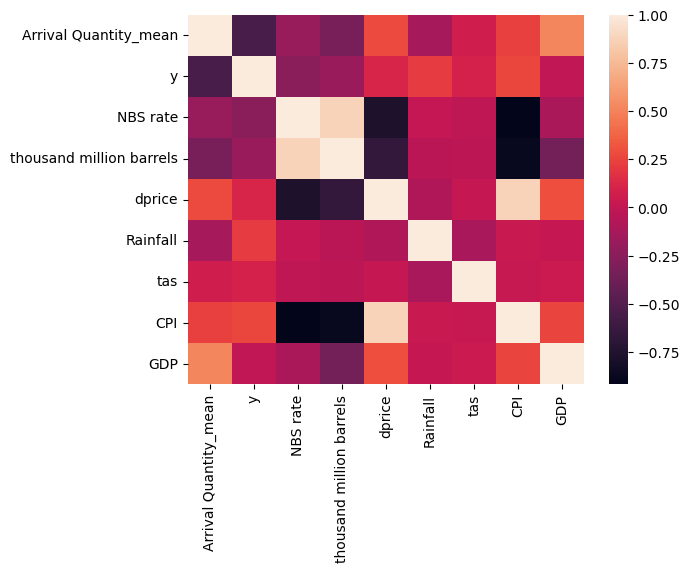

In [75]:
sns.heatmap(data=finaldf1.corr())

/tmp/ipykernel_20/2293981305.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

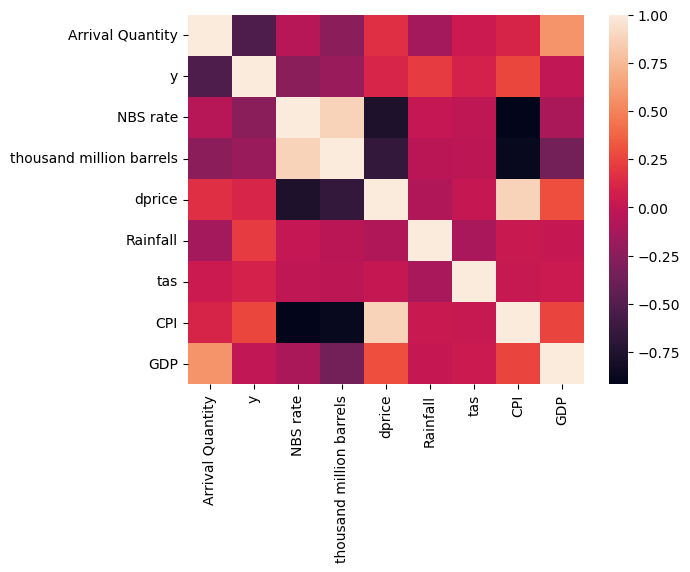

In [76]:
sns.heatmap(data=finaldf.corr())

# Dropping Diesel reserves,CPI and NBS rate

In [77]:
finaldf.drop(['thousand million barrels','CPI','NBS rate'],axis=1,inplace=True)
finaldf.columns

Index(['Arrival Quantity', 'y', 'dprice', 'Rainfall', 'tas', 'GDP', 'ds'], dtype='object')

In [78]:
finaldf1.drop(['thousand million barrels','CPI','NBS rate'],axis=1,inplace=True)
finaldf1.columns

Index(['Arrival Quantity_mean', 'y', 'dprice', 'Rainfall', 'tas', 'GDP', 'ds'], dtype='object')

# Using simple prophet model

In [79]:
# splitting train and test data
trainDataSize = 0.80
splitSize = int(finaldf.shape[0]*trainDataSize)
print(splitSize)
train = finaldf[0:splitSize]
test = finaldf[splitSize:]
print(train.shape)
print(test.shape)
Columns=finaldf.columns.tolist()
Columns.remove('y')
Columns.remove('ds')
prophetColumns =Columns
# model

model = Prophet()

# adding all columns in add regressor
for col in prophetColumns:
    model.add_regressor(col)
#training model
model.fit(train)

future =test.copy()
future.drop('y',axis=1,inplace=True)

#prediction
prediction = model.predict(future)

18:30:50 - cmdstanpy - INFO - Chain [1] start processing


95
(95, 7)
(24, 7)


18:30:51 - cmdstanpy - INFO - Chain [1] done processing


MAE: 739.659
MAPE: 0.37563301953153533


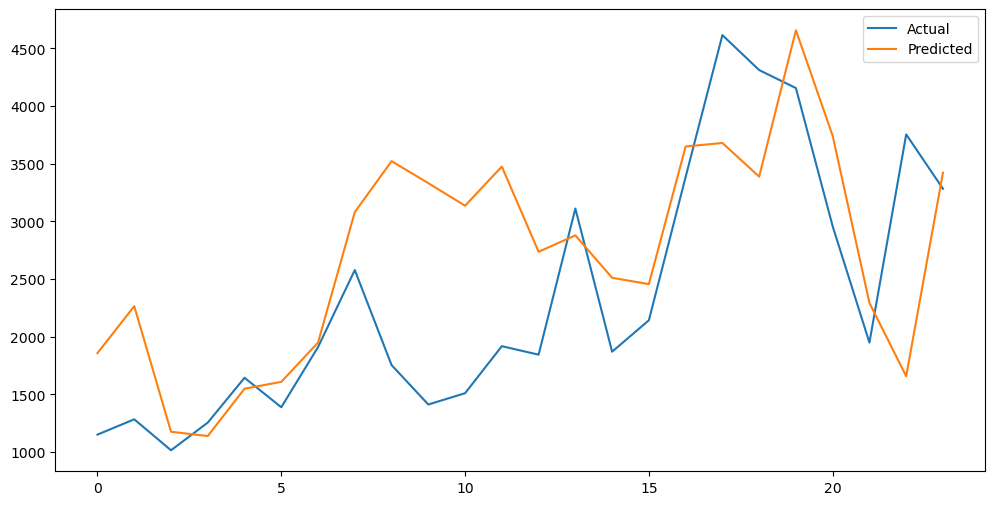

In [80]:
y_true = test['y'].values
y_pred = prediction['yhat'].values


plt.figure(figsize=(12, 6))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [81]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=test['ds'].values, y=y_true, name="actual targets"),)
    #secondary_y=False,)
fig.add_trace(
    go.Scatter(x=test['ds'].values, y=y_pred, name="predicted targets"),)
    #secondary_y=True,)
fig.add_trace(go.Scatter(x=finaldf['ds'].values, y=finaldf['y'].values, name="original data"),)
    #secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

# Modifying trend flexibility & amount of historical data to be included for detecting trend changepoints.

18:30:55 - cmdstanpy - INFO - Chain [1] start processing


95
(95, 7)
(24, 7)


18:30:57 - cmdstanpy - INFO - Chain [1] done processing


MAE: 672.088
MAPE: 0.3197388619425569


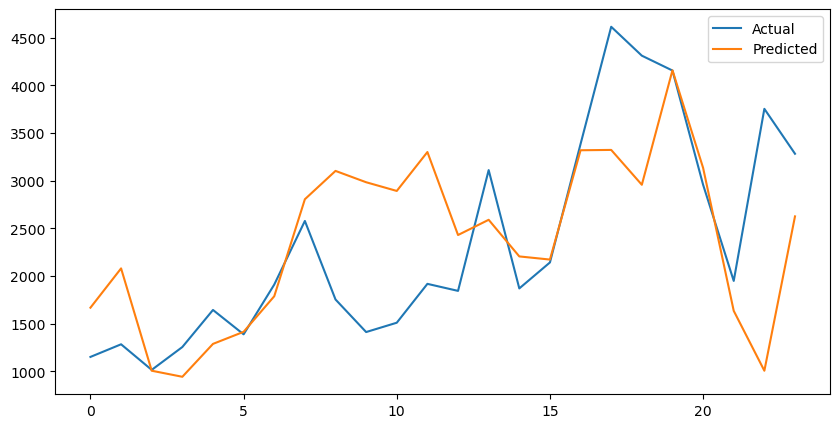

In [82]:
#Trial 2

# splitting train and test data
trainDataSize = 0.80
splitSize = int(finaldf.shape[0]*trainDataSize)
print(splitSize)
train = finaldf[0:splitSize]
test = finaldf[splitSize:]
print(train.shape)
print(test.shape)
Columns=finaldf.columns.tolist()
Columns.remove('y')
Columns.remove('ds')
prophetColumns =Columns
# model

#seasonality_mode = 'multiplicative'

#modelWeekly = Prophet(changepoint_range=0.90,changepoint_prior_scale = 0.5)

model = Prophet(changepoint_range=0.95,changepoint_prior_scale = 1,)#seasonality_prior_scale=20)

# adding all columns in add regressor
for col in prophetColumns:
    model.add_regressor(col)
#training model
model.fit(train)

future =test.copy()
future.drop('y',axis=1,inplace=True)

#prediction
prediction = model.predict(future)

y_true = test['y'].values
y_pred = prediction['yhat'].values


plt.figure(figsize=(10, 5))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [83]:
# with extreme weather and 80% train data, seasonality mode mulitplicative
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=test['ds'].values, y=y_true, name="actual targets"),)
    #secondary_y=False,)
fig.add_trace(
    go.Scatter(x=test['ds'].values, y=y_pred, name="predicted targets"),)
    #secondary_y=True,)
fig.add_trace(go.Scatter(x=finaldf['ds'].values, y=finaldf['y'].values, name="original data"),)
    #secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

In [84]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Arrival Quantity  119 non-null    float64       
 1   y                 119 non-null    float64       
 2   dprice            119 non-null    float64       
 3   Rainfall          119 non-null    float64       
 4   tas               119 non-null    float64       
 5   GDP               119 non-null    float64       
 6   ds                119 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 7.4 KB


# Implementing prophet model with 95% cofidence interval

In [85]:
def model_prophet(Prophetdf,n_obs= 113):

    Prophetdf_train=Prophetdf[0:n_obs]
    Prophetdf_test =Prophetdf[n_obs:]
    multi_model = Prophet(interval_width = 0.95)
    Prophet_cols = Prophetdf.columns.tolist()
    Prophet_cols.remove('ds')
    Prophet_cols.remove('y')
    print(Prophetdf_train.columns)
    #print(Prophetdf_test[['ds','y']])

    # adding all columns in add regressor
    for col in Prophet_cols:
        multi_model.add_regressor(col)


    multi_model.fit(Prophetdf_train)
    print('Prophetdf_test.shape[0]')
    print(Prophetdf_test.shape[0])
    # make furture frame
    future = multi_model.make_future_dataframe(periods = Prophetdf_test.shape[0],freq='MS', include_history=True)
    for col in Prophet_cols:
        future[col] =Prophetdf[col]
    print(Prophetdf_test[['ds','y']])
    print('future')
    print(future)

    # predict future
    forecastProphet =  multi_model.predict(future)
    combined_df = pd.merge(Prophetdf_test[['ds','y']],forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

    print(forecastProphet[['ds','yhat', 'yhat_lower','yhat_upper']].tail())

    fig1 = multi_model.plot(forecastProphet)

    Prophetdf.plot(x = 'ds', y = 'y')

    multi_model.plot_components(forecastProphet);


    #print(Prophetdf_test[['ds','y']])
    print(forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-6:])

    combined_df = pd.merge(Prophetdf_test[['ds','y']],forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-6:], on='ds')
    #print(combined_df.head())


    #Check MAE value
    MAE = mean_absolute_error(combined_df['y'], combined_df['yhat'])
    print('MAE')
    print(MAE)

#Check MAPE value
    MAPE = mean_absolute_percentage_error(combined_df['y'], combined_df['yhat'])
    print('MAPE')
    print(MAPE)

    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.rcParams.update({'figure.figsize':  (15, 3),  'figure.dpi' : 300})
    fig, ax = plt.subplots()

    sns.lineplot(data = Prophetdf , x = 'ds', y = 'y' ,label = 'Original')
    sns.lineplot(data= forecastProphet, x = 'ds', y = 'yhat', label = 'Forecast')
    plt.grid(linestyle = '-', linewidth = 0.3)

    plt.legend(["Original","forecast"])


    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.rcParams.update({'figure.figsize':  (15, 3),  'figure.dpi' : 300})
    fig, ax = plt.subplots()
    sns.lineplot(data = Prophetdf[-6:] , x = 'ds', y = 'y' ,label = 'Original')
    sns.lineplot(data= forecastProphet[-6:], x = 'ds', y = 'yhat', label = 'Forecast')
    plt.grid(linestyle = '-', linewidth = 0.3)
    plt.legend(["Original","forecast"])




    return MAE

In [86]:
finaldf.head()

Arrival Quantity            y     dprice  Rainfall        tas        GDP  \
0        382.777778  1628.571429  37.133685       0.1  26.800001   99.41989   
1        436.875000   928.333333  38.096676       0.0  29.400000   99.62147   
2        435.000000   801.075269  39.456193       0.0  31.800001   99.81792   
3        415.294118  1328.494624  40.135951     123.5  33.600002  100.00665   
4        322.941176  2531.720430  40.815709     123.3  33.000000  100.18442   

          ds  
0 2010-02-01  
1 2010-03-01  
2 2010-04-01  
3 2010-05-01  
4 2010-06-01

In [87]:
finaldf1.head()

Arrival Quantity_mean            y     dprice  Rainfall        tas  \
0            7694.600912  1628.571429  37.133685       0.1  26.800001   
1           12587.995399   928.333333  38.096676       0.0  29.400000   
2           13093.057589   801.075269  39.456193       0.0  31.800001   
3           11923.100490  1328.494624  40.135951     123.5  33.600002   
4            9716.699346  2531.720430  40.815709     123.3  33.000000   

         GDP         ds  
0   99.41989 2010-02-01  
1   99.62147 2010-03-01  
2   99.81792 2010-04-01  
3  100.00665 2010-05-01  
4  100.18442 2010-06-01

In [88]:
finaldf1.iplot(subplots=True)

In [89]:
#HERE we can see that MAE for arrival quantity mean(589.63) resampling is significantly less than that calculated using max resampling(608.94)

# For arrival (max attribute) 

18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:08 - cmdstanpy - INFO - Chain [1] done processing


Index(['Arrival Quantity', 'y', 'dprice', 'Rainfall', 'tas', 'GDP', 'ds'], dtype='object')
Prophetdf_test.shape[0]
6
            ds            y
113 2019-07-01  4311.290323
114 2019-08-01  4155.376344
115 2019-09-01  2957.526882
116 2019-10-01  1949.193548
117 2019-11-01  3753.763441
118 2019-12-01  3282.795699
future
            ds  Arrival Quantity     dprice  Rainfall        tas        GDP
0   2010-02-01        382.777778  37.133685       0.1  26.800001   99.41989
1   2010-03-01        436.875000  38.096676       0.0  29.400000   99.62147
2   2010-04-01        435.000000  39.456193       0.0  31.800001   99.81792
3   2010-05-01        415.294118  40.135951     123.5  33.600002  100.00665
4   2010-06-01        322.941176  40.815709     123.3  33.000000  100.18442
..         ...               ...        ...       ...        ...        ...
114 2019-08-01        375.555556  70.800605     170.5  31.100000  100.58100
115 2019-09-01        390.625000  71.480363     207.6  30.100000  100.43

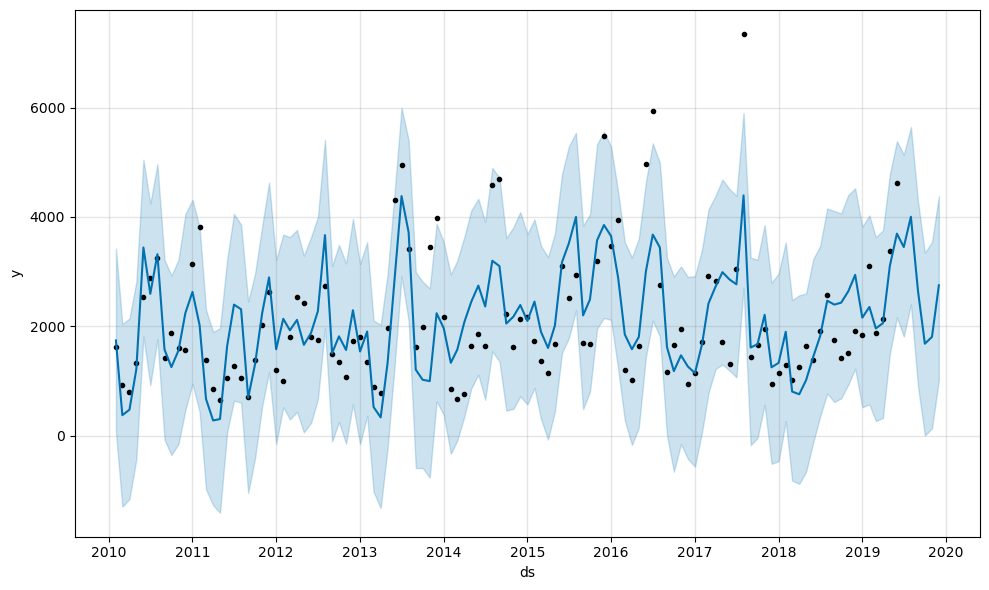

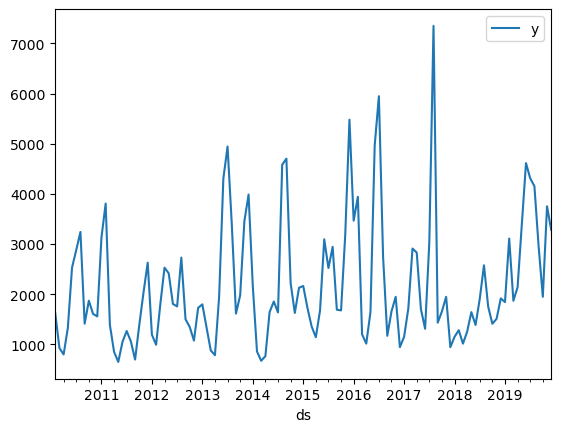

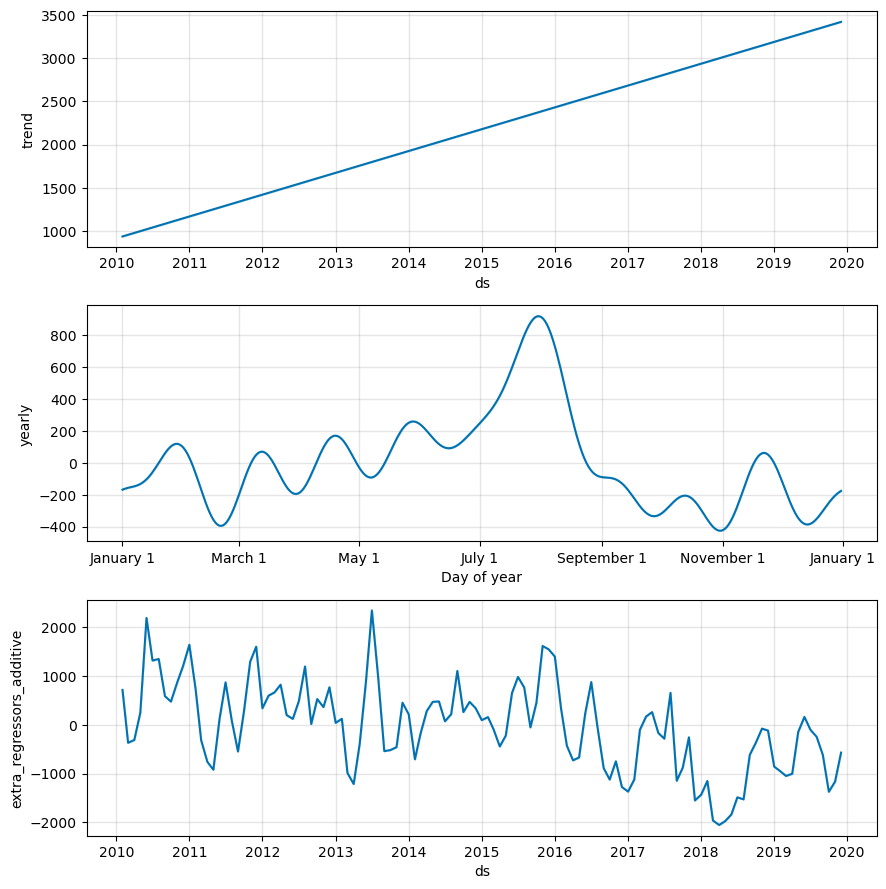

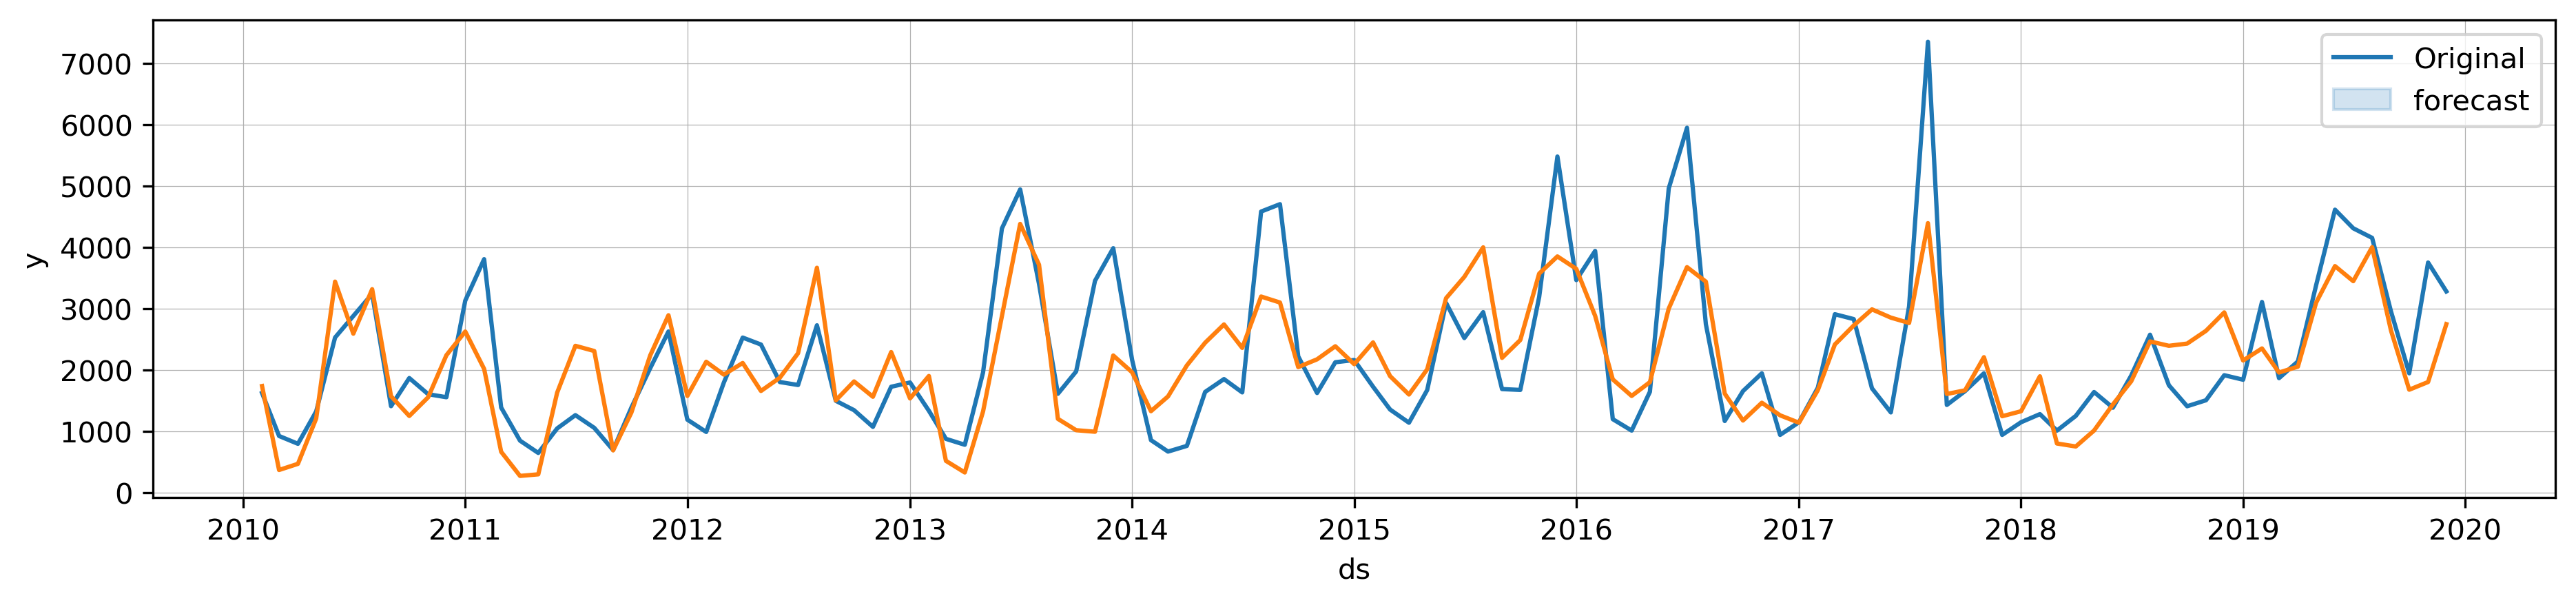

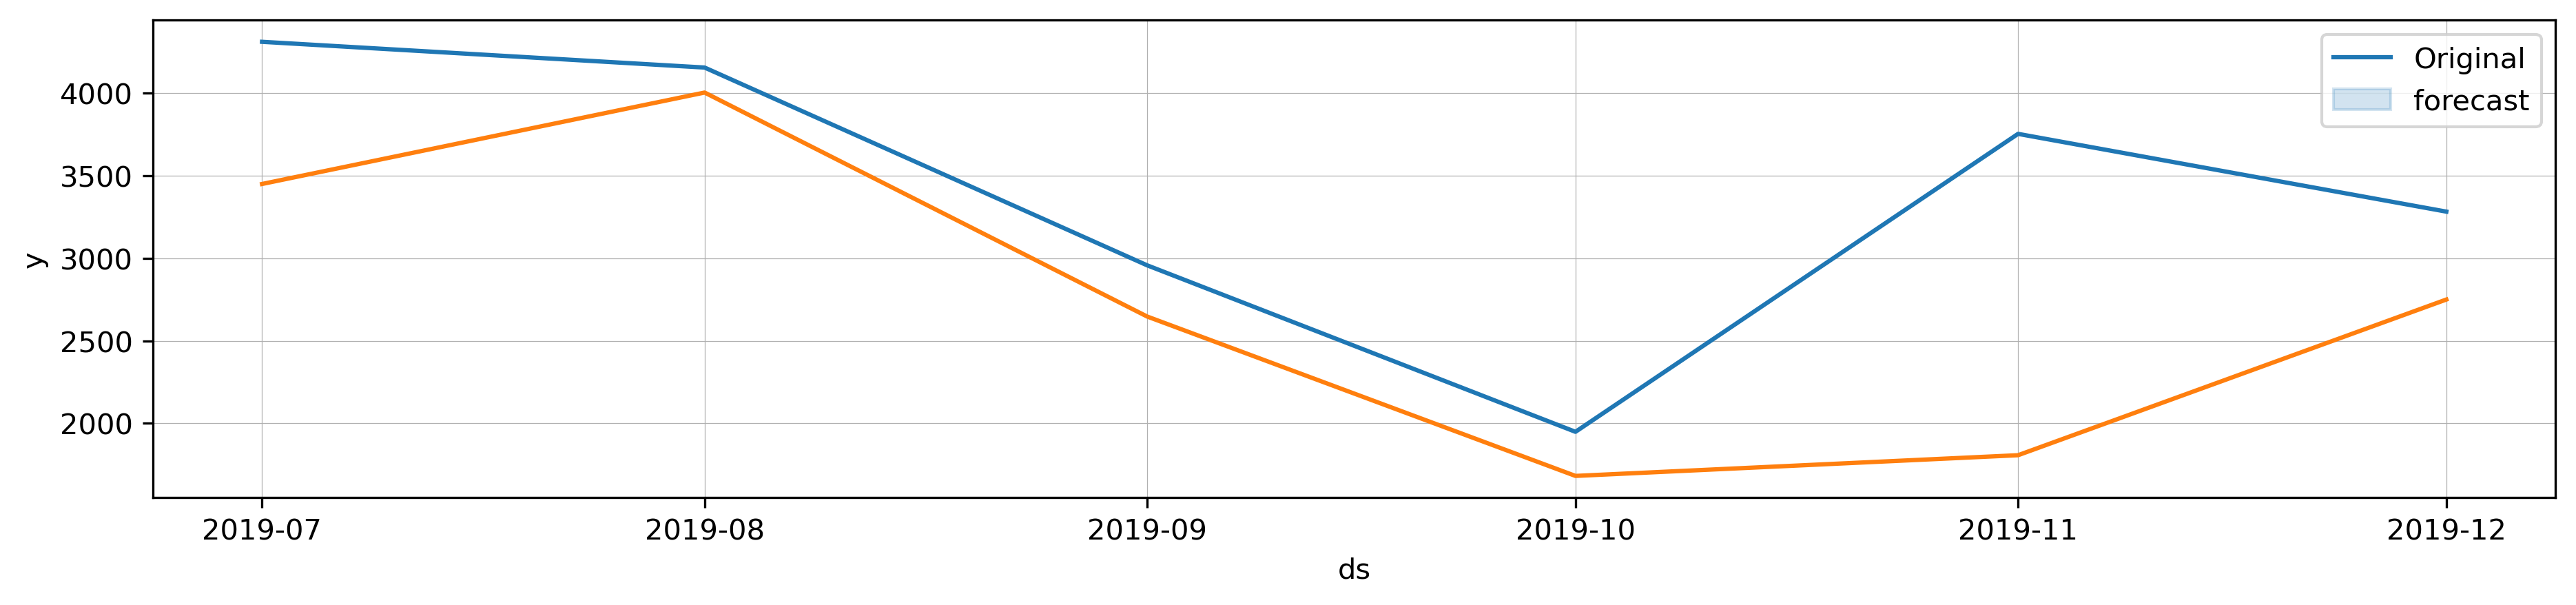

In [90]:
MAE_Prophet = model_prophet(finaldf)

# For arrival (sum attribute) 

18:31:13 - cmdstanpy - INFO - Chain [1] start processing
18:31:13 - cmdstanpy - INFO - Chain [1] done processing


Index(['Arrival Quantity_mean', 'y', 'dprice', 'Rainfall', 'tas', 'GDP', 'ds'], dtype='object')
Prophetdf_test.shape[0]
6
            ds            y
113 2019-07-01  4311.290323
114 2019-08-01  4155.376344
115 2019-09-01  2957.526882
116 2019-10-01  1949.193548
117 2019-11-01  3753.763441
118 2019-12-01  3282.795699
future
            ds  Arrival Quantity_mean     dprice  Rainfall        tas  \
0   2010-02-01            7694.600912  37.133685       0.1  26.800001   
1   2010-03-01           12587.995399  38.096676       0.0  29.400000   
2   2010-04-01           13093.057589  39.456193       0.0  31.800001   
3   2010-05-01           11923.100490  40.135951     123.5  33.600002   
4   2010-06-01            9716.699346  40.815709     123.3  33.000000   
..         ...                    ...        ...       ...        ...   
114 2019-08-01           11525.263158  70.800605     170.5  31.100000   
115 2019-09-01           11706.289087  71.480363     207.6  30.100000   
116 2019-10-01    

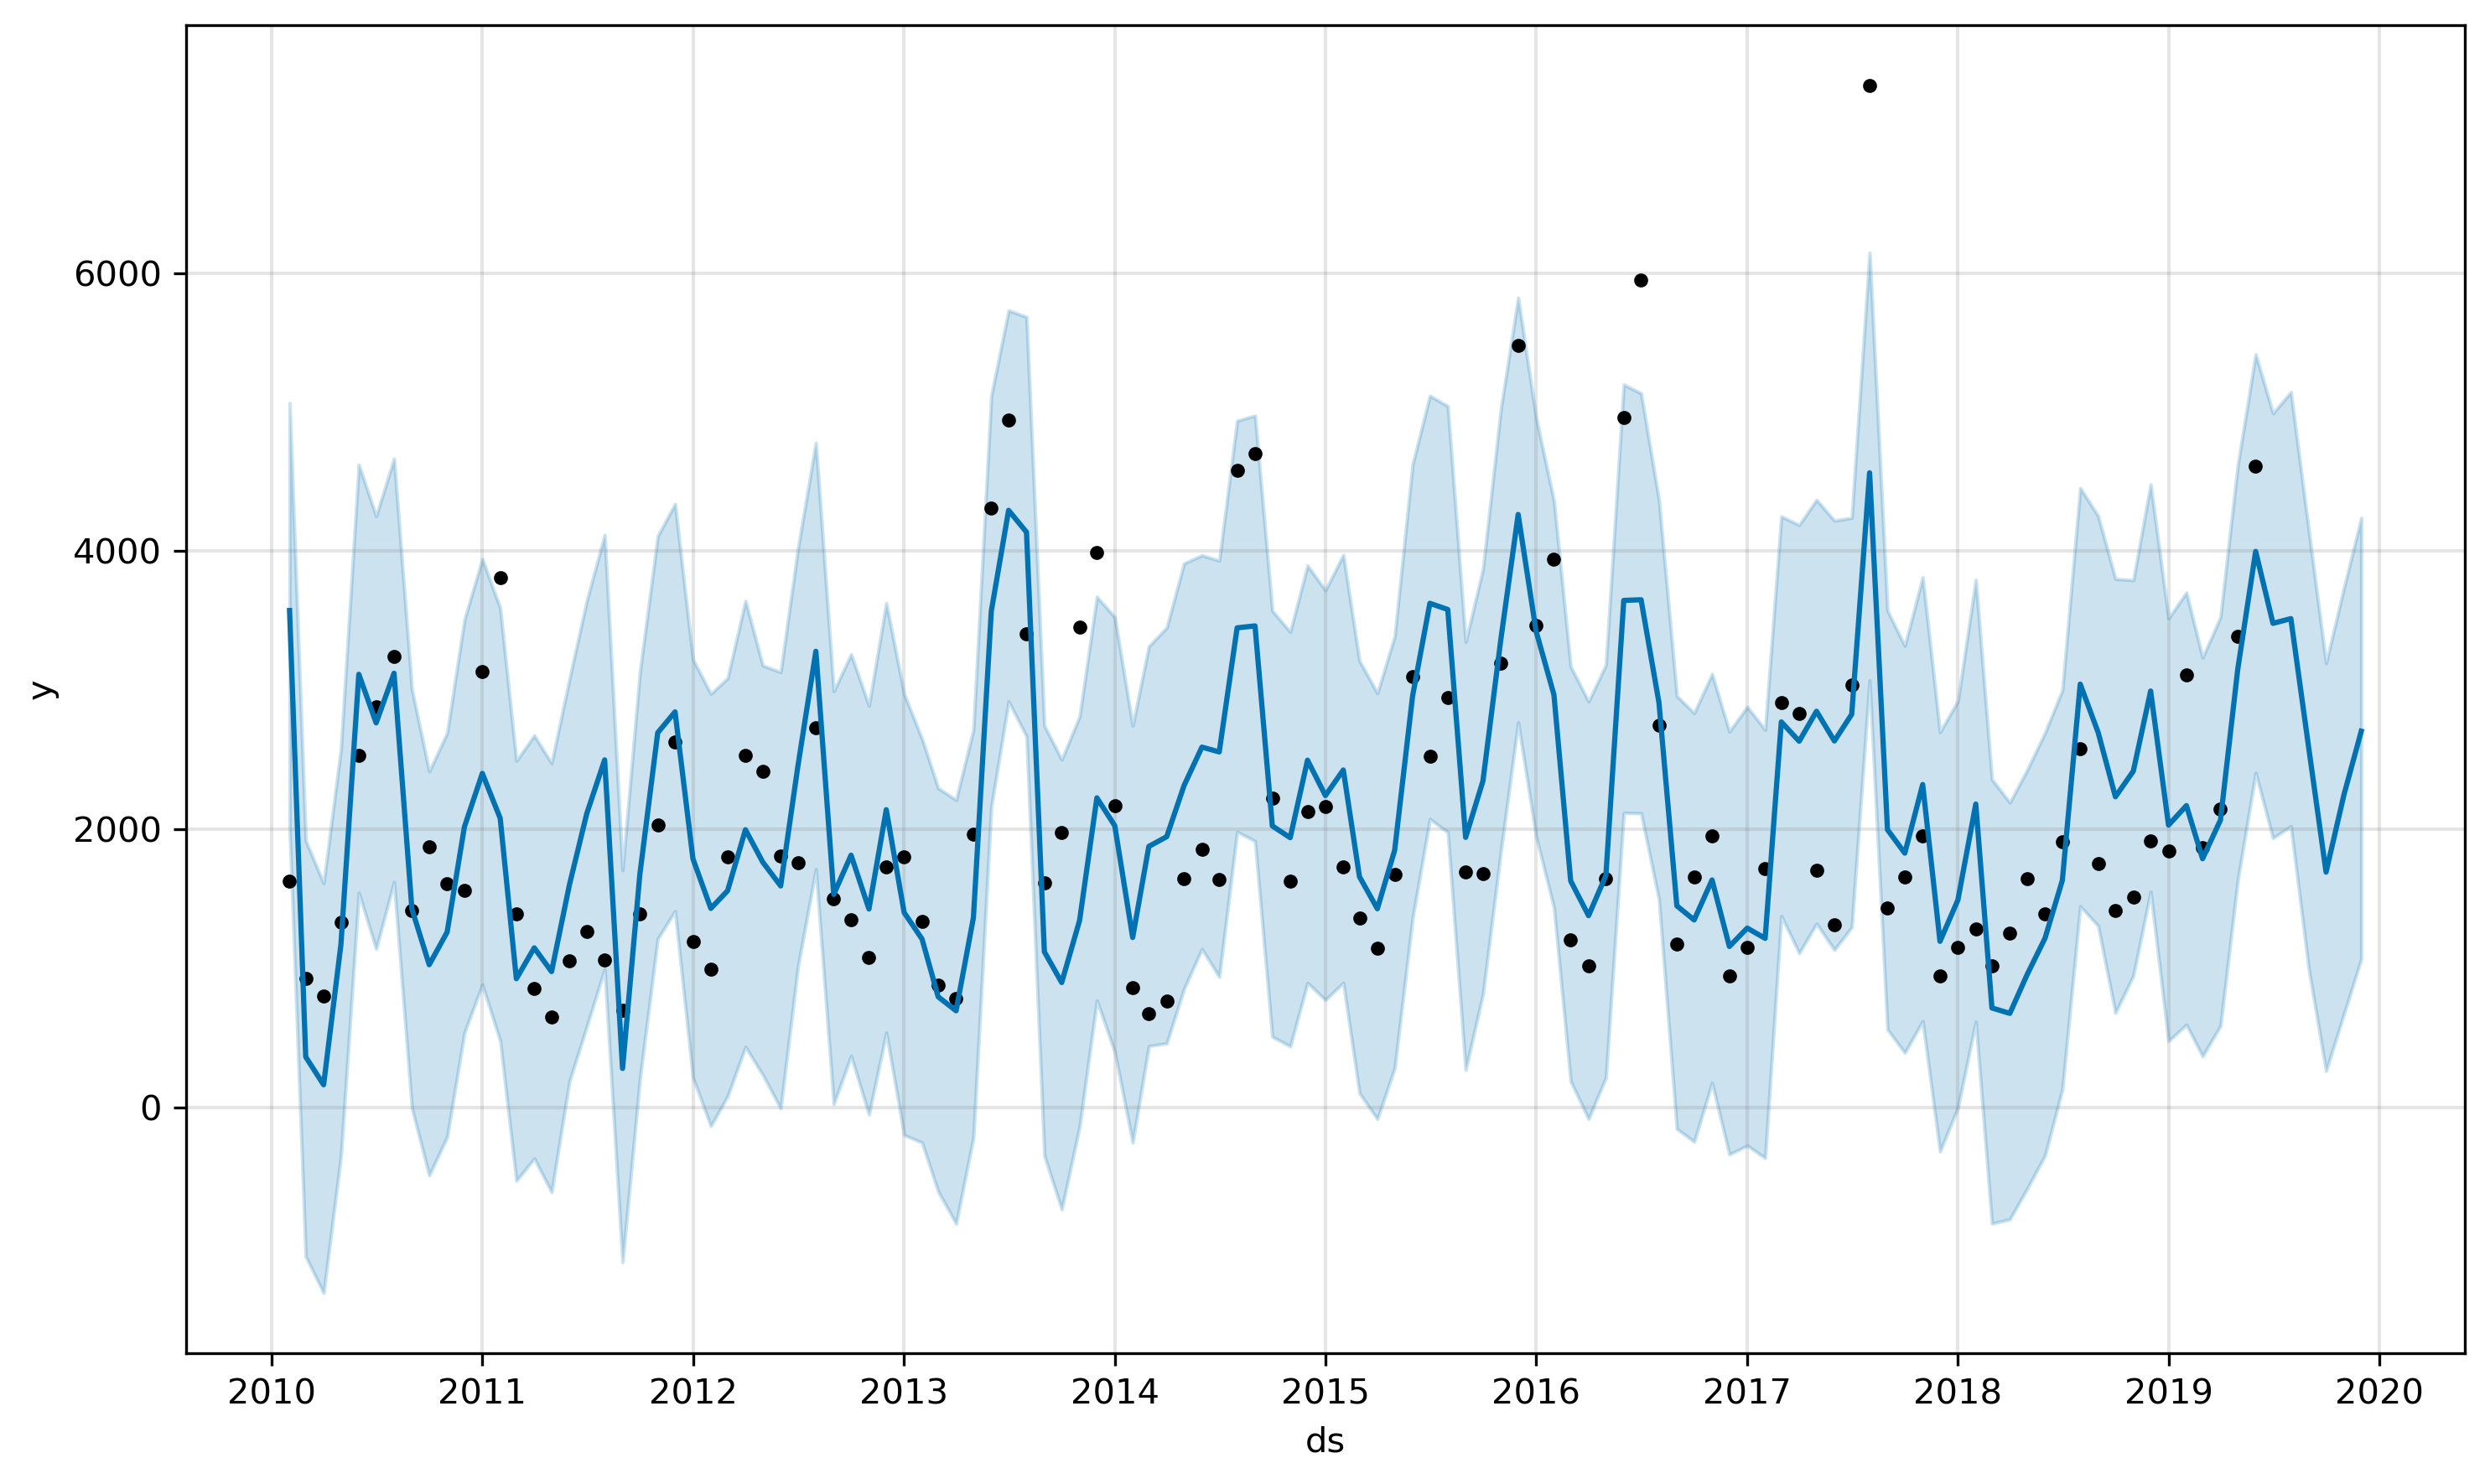

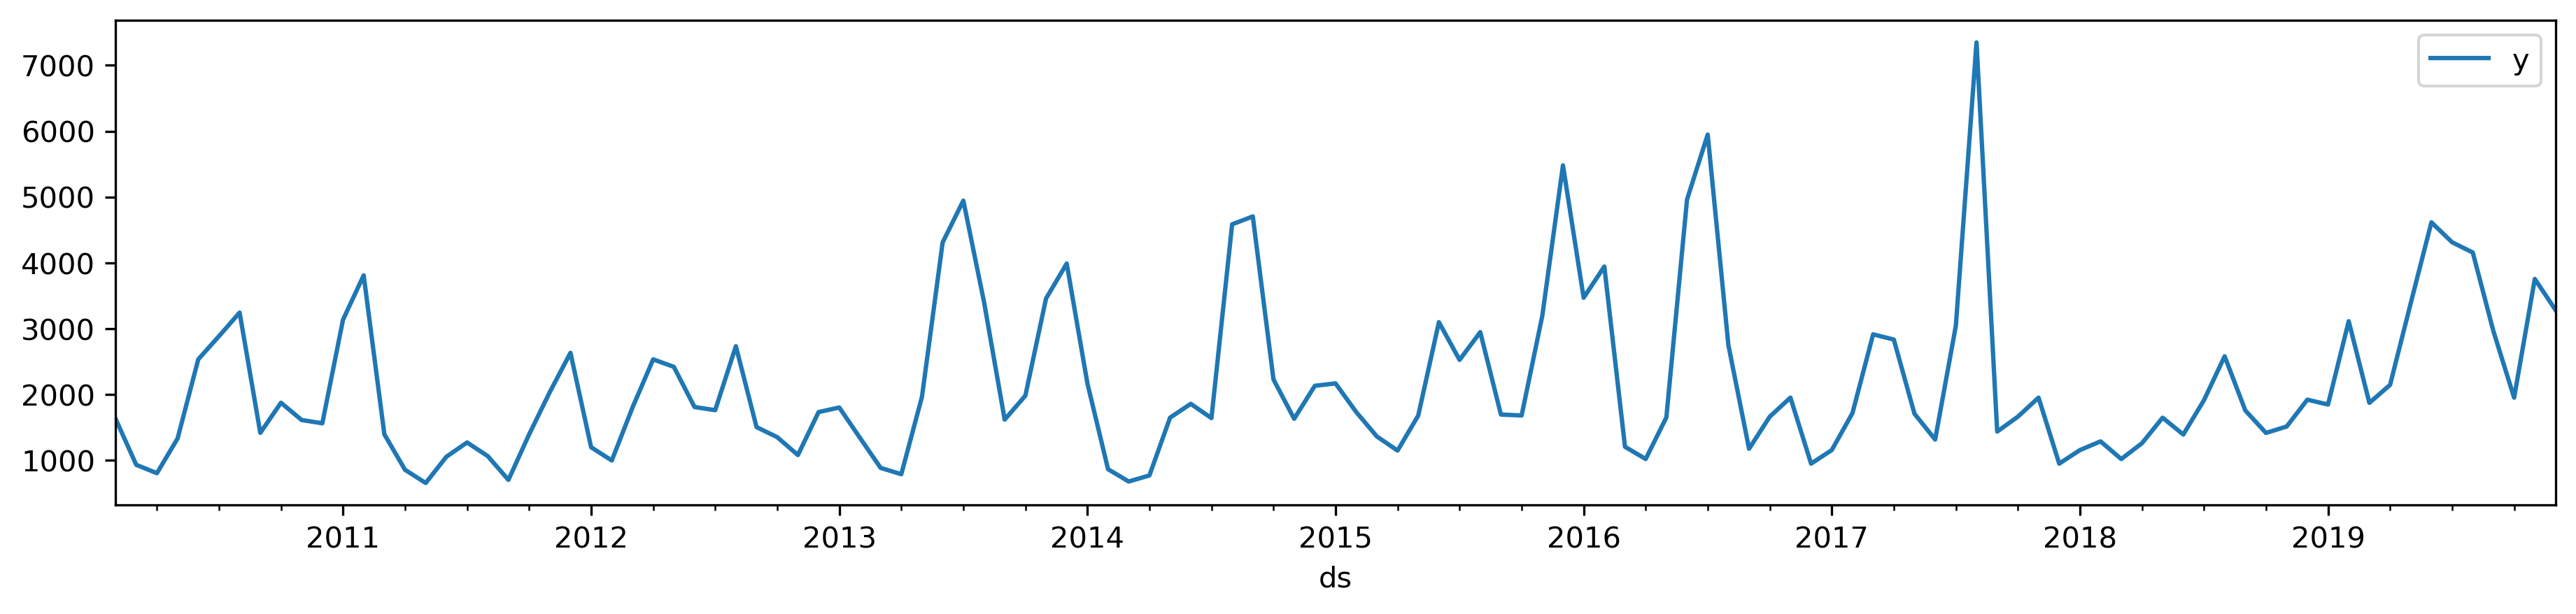

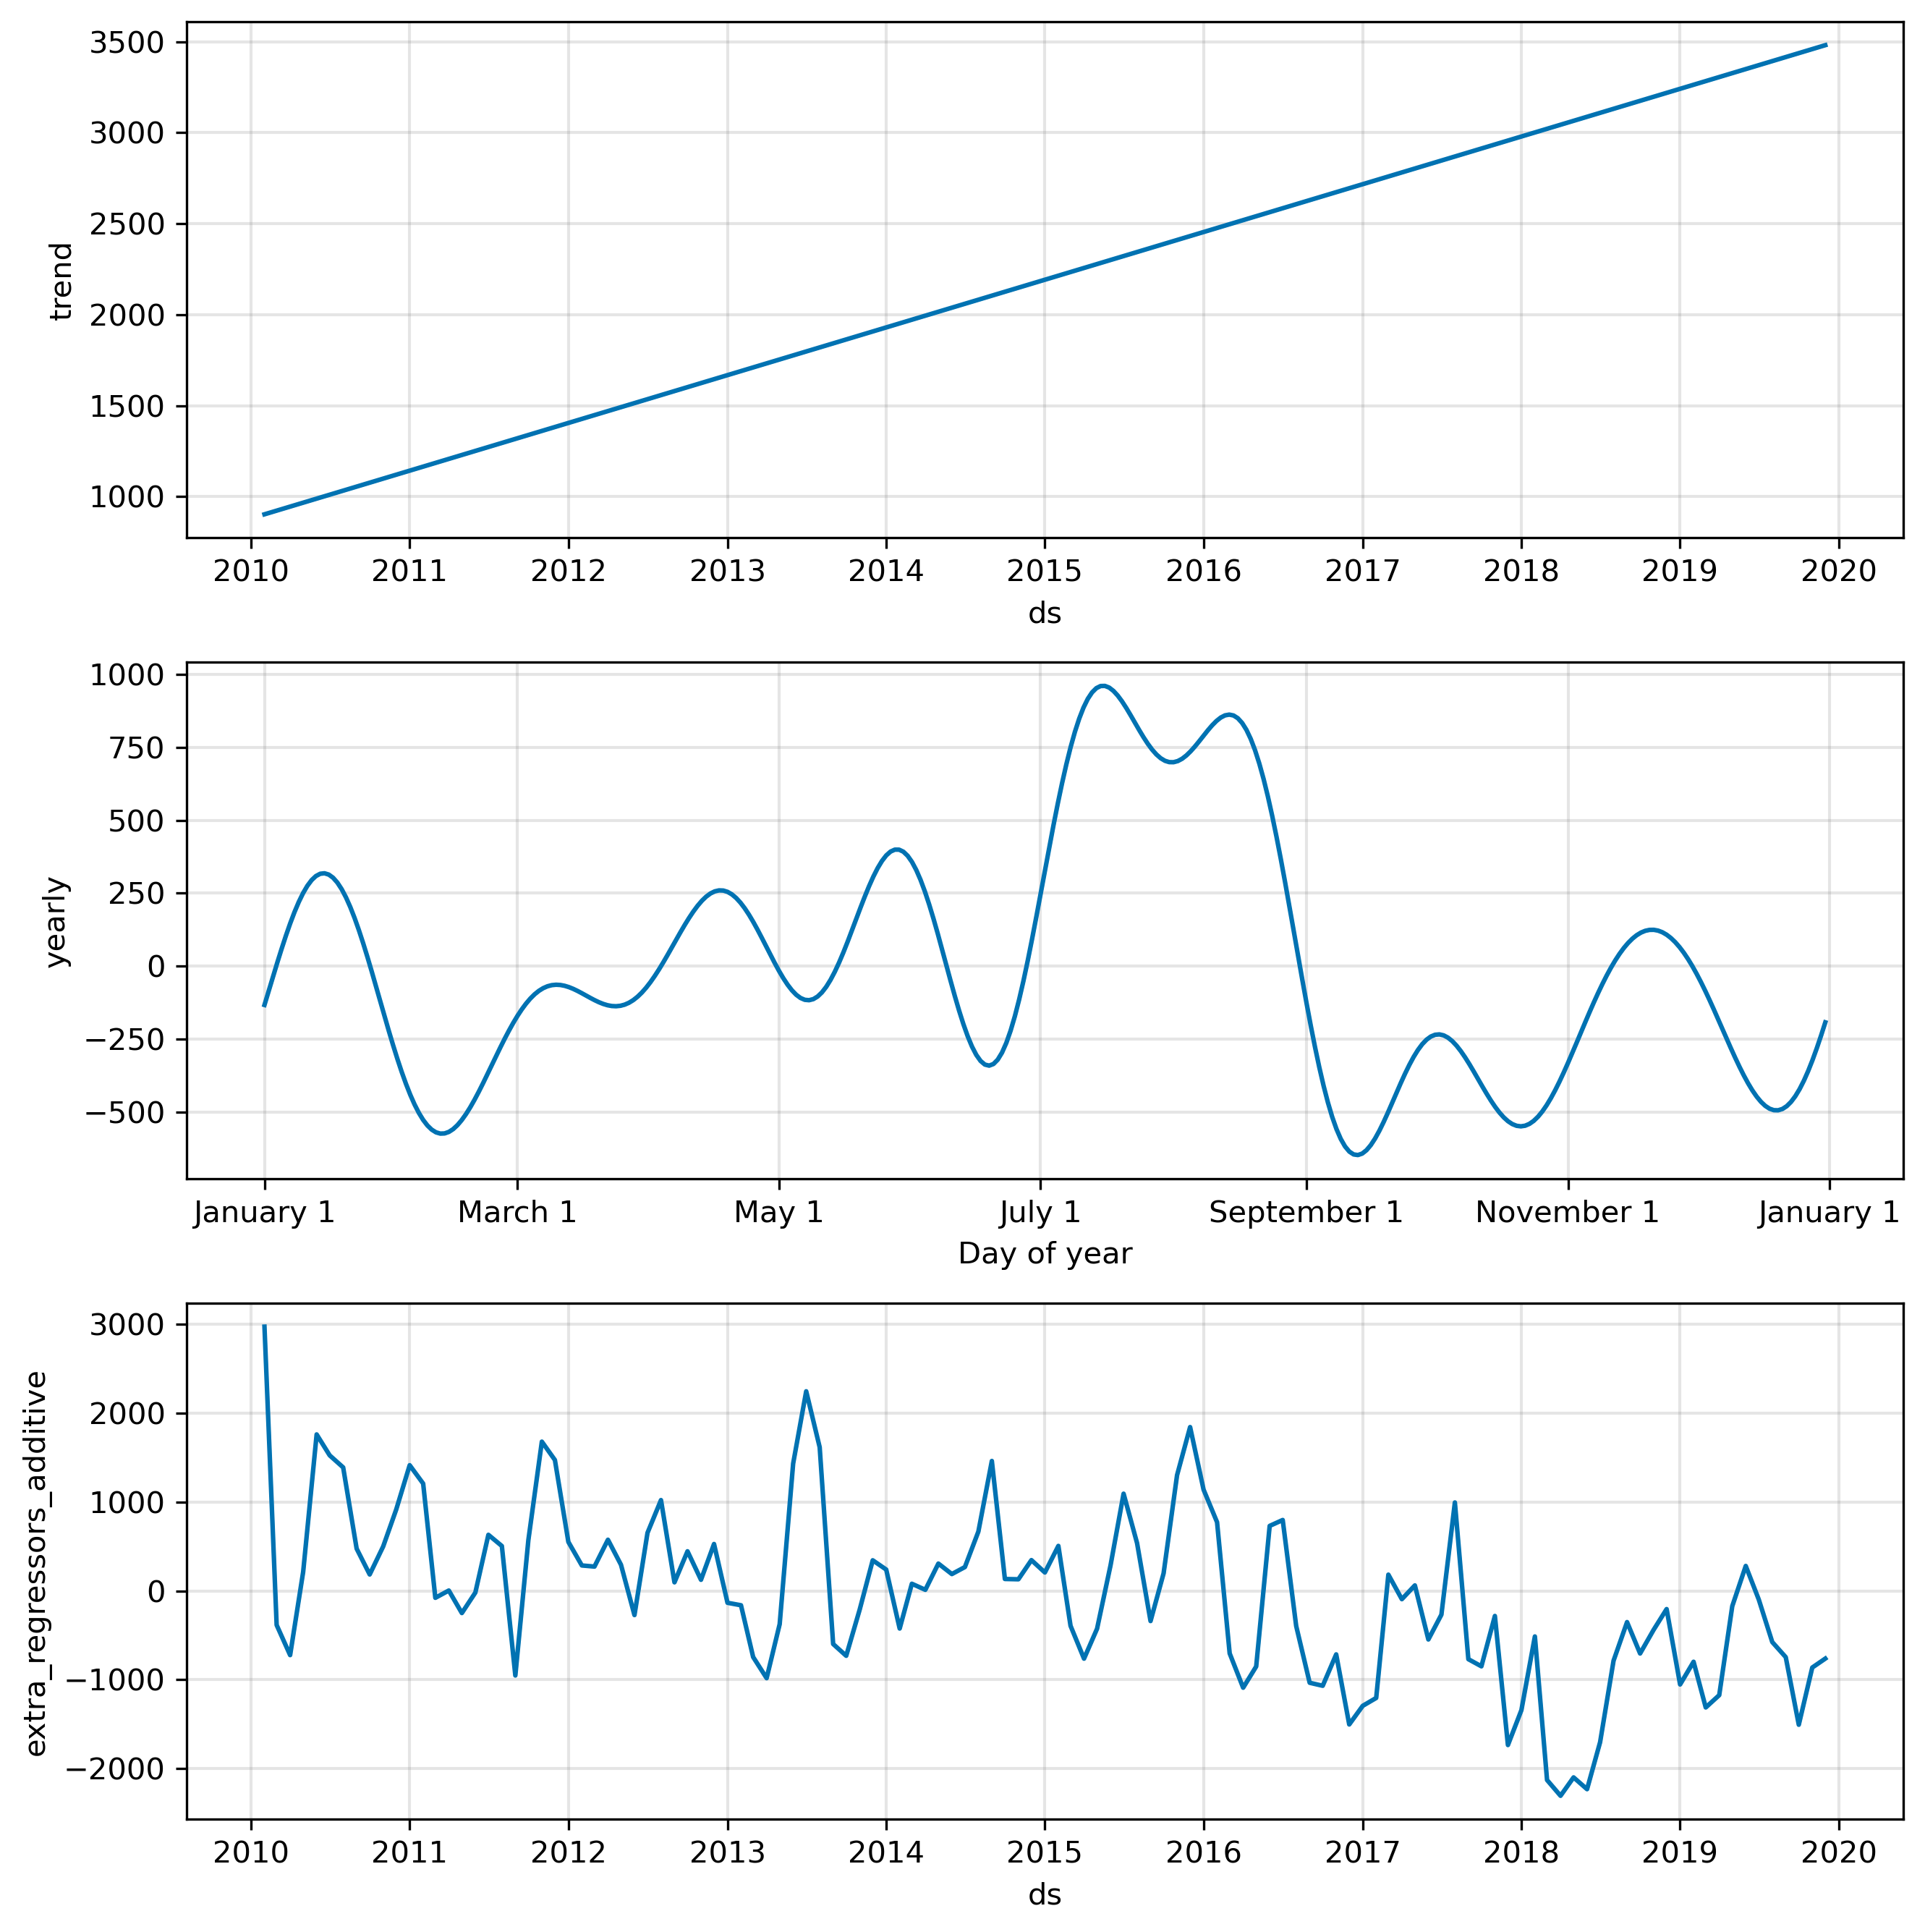

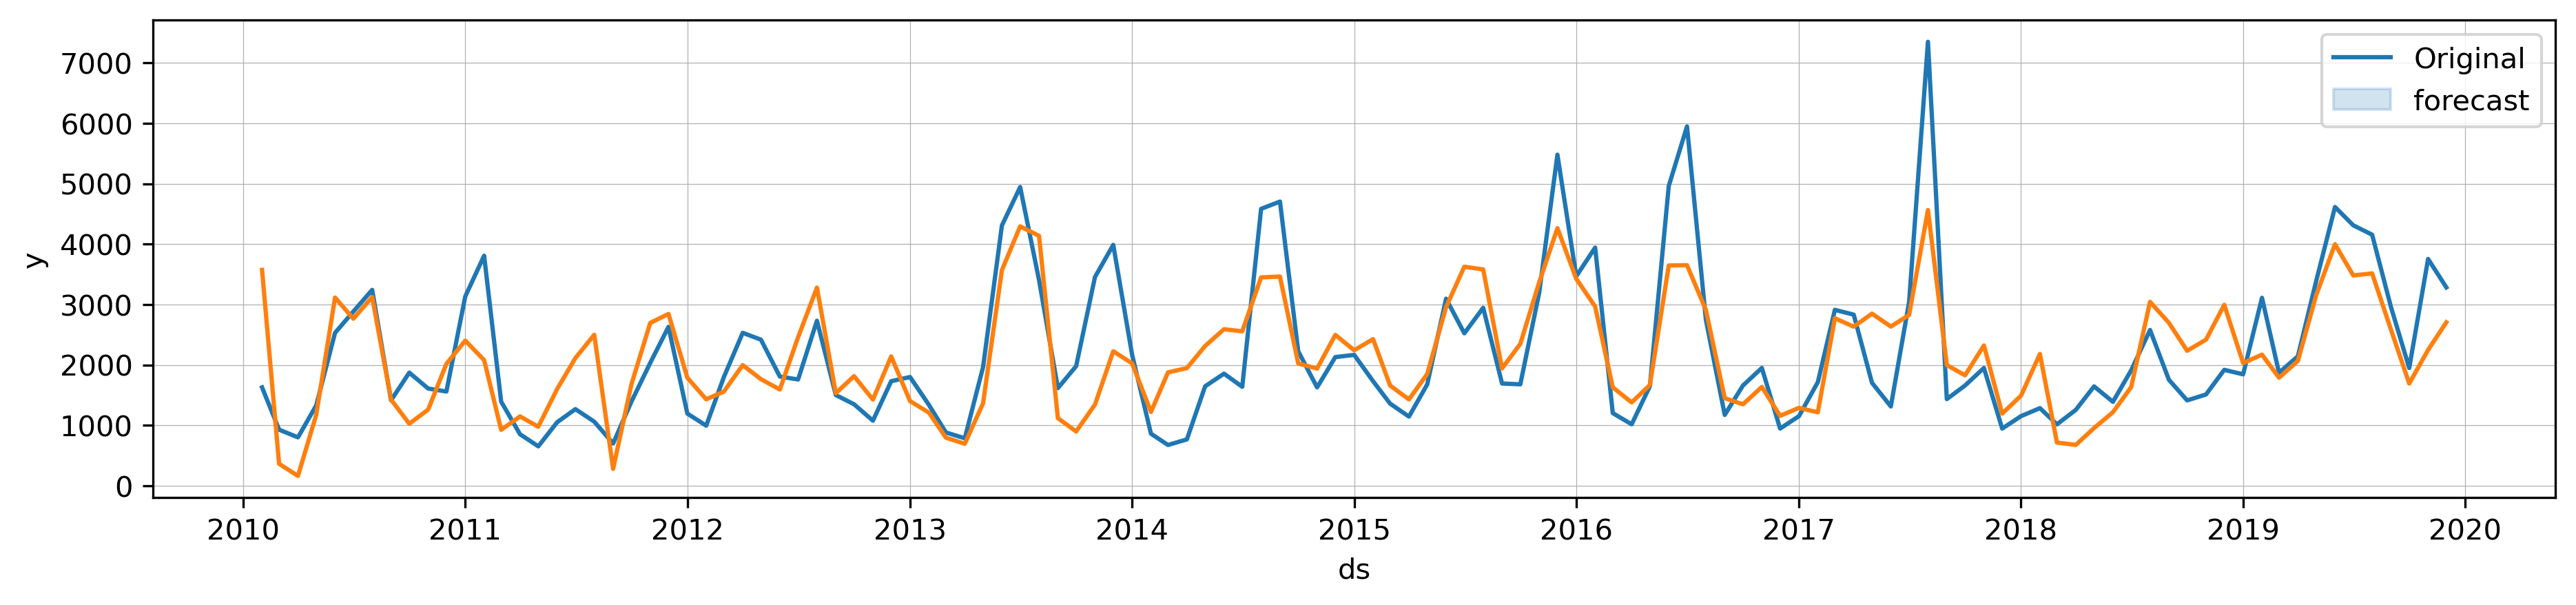

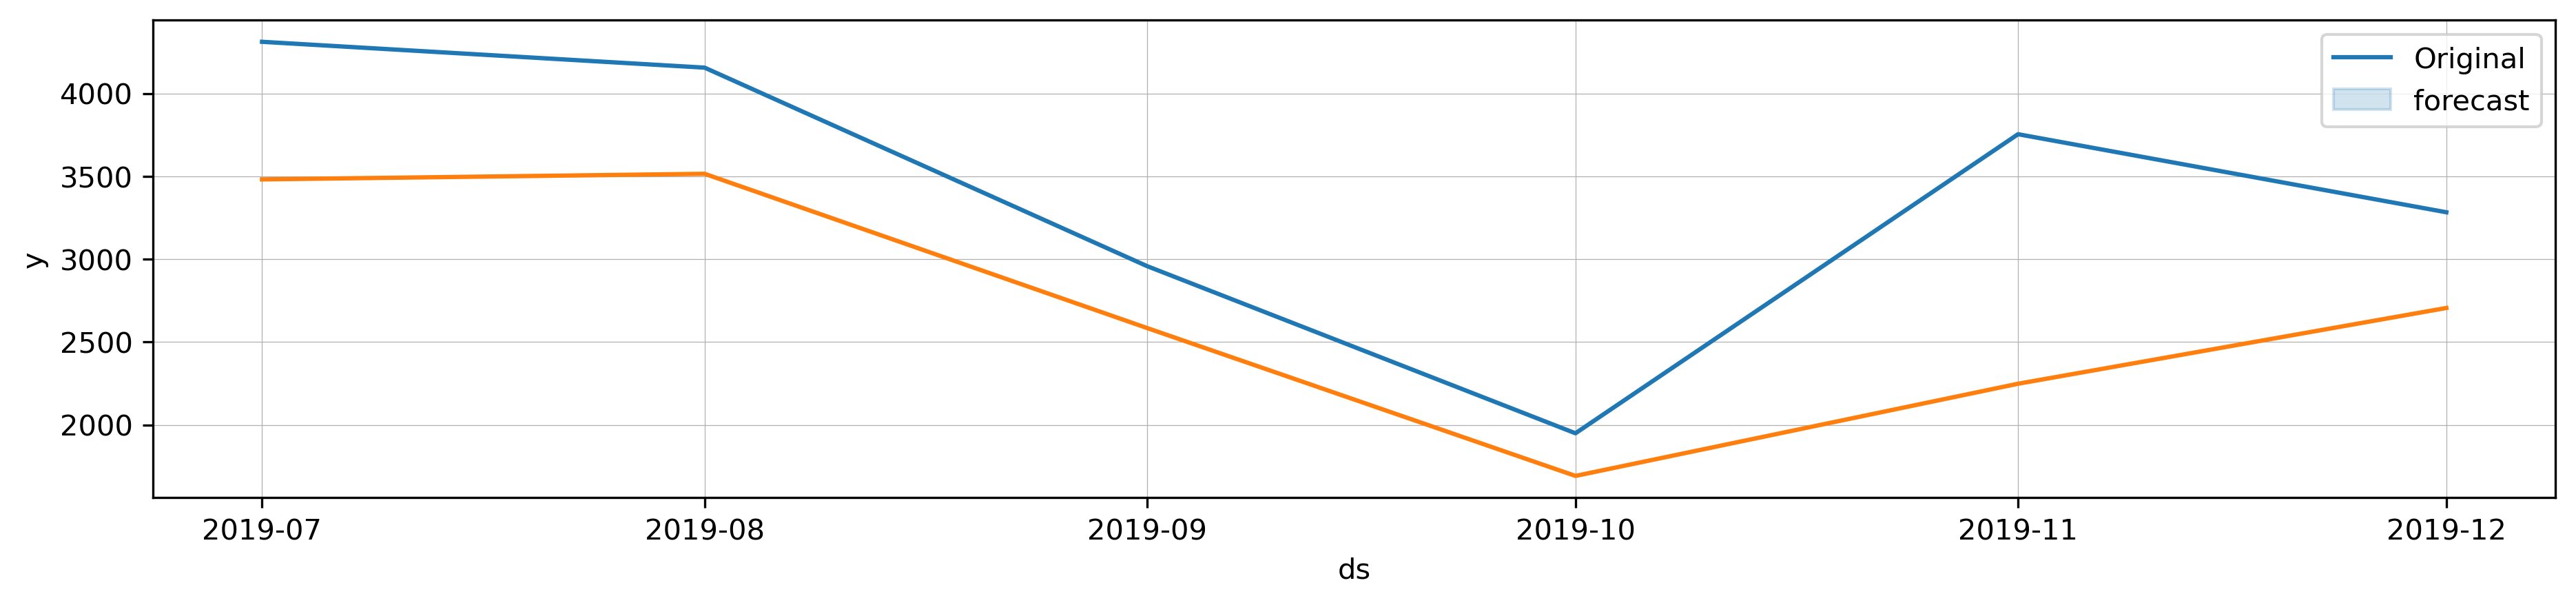

In [91]:
MAE_Prophet_1=model_prophet(finaldf1)